# Mitigating Risk of Obesity with Early Detection using Machine Learning Techniques

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.feature_selection import SelectKBest,chi2,SelectPercentile
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import RFE
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn import tree
from sklearn.pipeline import make_pipeline
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve

In [4]:
import warnings
from sklearn.exceptions import DataConversionWarning
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Ignore data conversion warnings
warnings.simplefilter(action='ignore', category=DataConversionWarning)

# Import dataset using pandas dataframe

In [291]:
Ob = pd.read_csv('Obesity.csv')
print(Ob.head())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

# Exploratory Data Analysis

In [292]:
Ob.dtypes
Ob.info()
sorted_labels = ['Insufficient_Weight', 'Normal_Weight', 
 'Overweight_Level_I', 'Overweight_Level_II', 
 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

# Check if there is missing value
missing_values = Ob.isnull().sum()
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
# There are no missing values in the dataset as all columns have the same number of non-null entries as the
# number of rows in the dataset.

In [308]:
# Validate if the dataset is balance

dist = Ob['NObeyesdad'].value_counts()
print(dist)
#descriptive = Ob.describe()
#print(descriptive)

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


### Class Imbalance check distribution plot

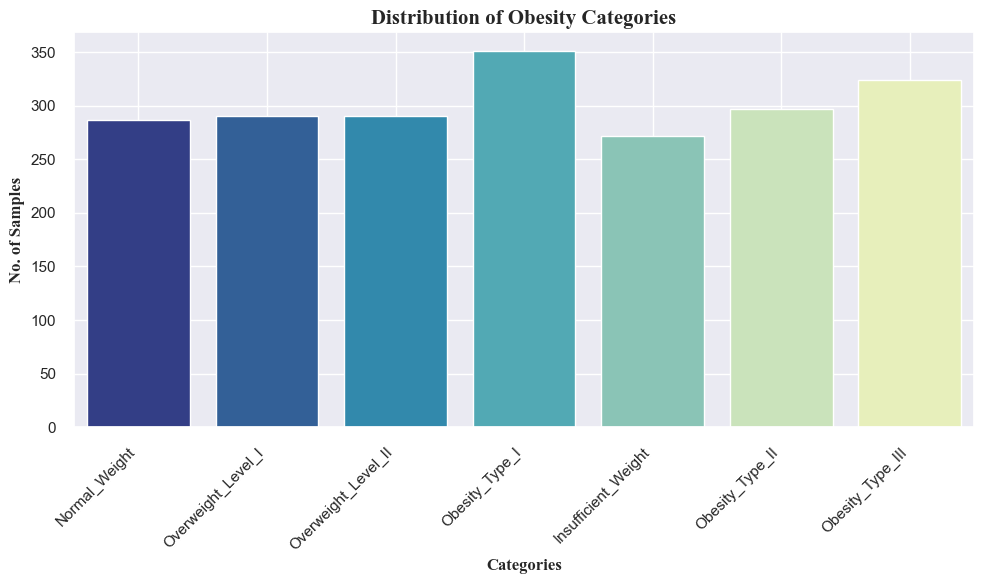

In [295]:
plt.figure(figsize=(10, 6))
sns.countplot(data=Ob, x='NObeyesdad', palette='YlGnBu_r')
plt.title('Distribution of Obesity Categories', size=15, family='Times New Roman', weight='bold')
plt.xlabel('Categories', size=12, family='Times New Roman', weight='bold')
plt.ylabel('No. of Samples', size=12, family='Times New Roman', weight='bold')
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### The class distribution shows that the dataset is fairly balanced across the different obesity levels.

# Data preprocessing and encoding

In [296]:
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()

# Target encode
label_encoder.fit(Ob['NObeyesdad'])
Y = label_encoder.transform(Ob['NObeyesdad'])
Y = pd.Series(Y)
Y = Y.to_frame(name='Target')
class_types = label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6])

# Features data processing
Ob = Ob.rename(columns={'family_history_with_overweight':'Family_History'})


In [297]:
# Features Encoding
CAT = ['Gender', 'Family_History', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
data_encoded = ordinal_encoder.fit_transform(Ob[CAT])
cat_encode = pd.DataFrame(data_encoded,columns=ordinal_encoder.get_feature_names_out(CAT))
features_encode = Ob.drop(['NObeyesdad'],axis =1)
features_encode = features_encode.drop(columns=CAT)
X = pd.concat([cat_encode,features_encode],axis=1)
print(X)

      Gender  Family_History  FAVC  CAEC  SMOKE  SCC  CALC  MTRANS        Age  \
0        0.0             1.0   0.0   2.0    0.0  0.0   3.0     3.0  21.000000   
1        0.0             1.0   0.0   2.0    1.0  1.0   2.0     3.0  21.000000   
2        1.0             1.0   0.0   2.0    0.0  0.0   1.0     3.0  23.000000   
3        1.0             0.0   0.0   2.0    0.0  0.0   1.0     4.0  27.000000   
4        1.0             0.0   0.0   2.0    0.0  0.0   2.0     3.0  22.000000   
...      ...             ...   ...   ...    ...  ...   ...     ...        ...   
2106     0.0             1.0   1.0   2.0    0.0  0.0   2.0     3.0  20.976842   
2107     0.0             1.0   1.0   2.0    0.0  0.0   2.0     3.0  21.982942   
2108     0.0             1.0   1.0   2.0    0.0  0.0   2.0     3.0  22.524036   
2109     0.0             1.0   1.0   2.0    0.0  0.0   2.0     3.0  24.361936   
2110     0.0             1.0   1.0   2.0    0.0  0.0   2.0     3.0  23.664709   

        Height      Weight 

### Correlation Analysis

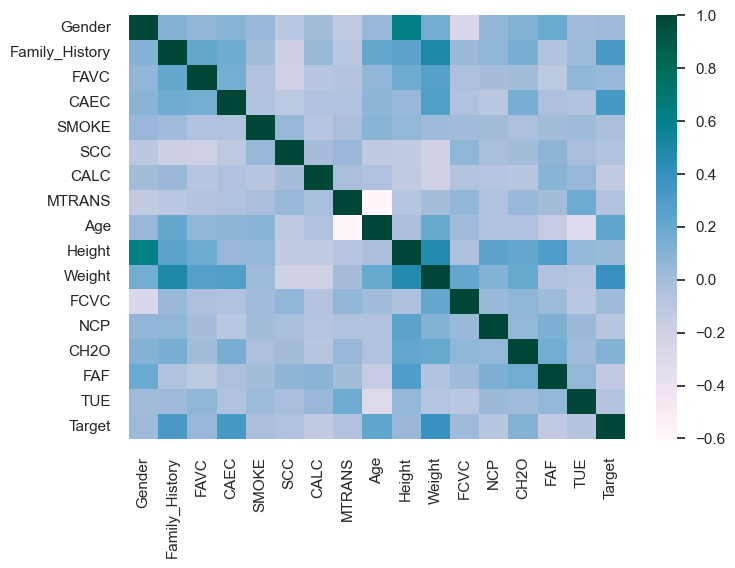

In [298]:
corr = pd.concat([X,Y],axis=1)
correlation = corr.corr()

sns.heatmap(correlation,cmap='PuBuGn')
plt.show()

> Overall correlation between features are mostly weakly correlated, PCA may not be required

#### Further analysis of data normality to confirmed if PCA is applicable

In [13]:
import pingouin as pg


scaler = StandardScaler()
corr_scaled = scaler.fit_transform(corr)
#print(corr_scaled)

# Perform Mardia's test for multivariate normality
mardia_test = pg.multivariate_normality(corr_scaled, alpha=.05)
print(f"Multivariate normality test results:\n{mardia_test}")

Multivariate normality test results:
HZResults(hz=12.779368376293235, pval=0.0, normal=False)


#### PCA is not suitable for our dataset as it is not normally distributed

# Preparing train and test set

In [300]:
# Split Data for training and test sets
X_train , X_test , Y_train , Y_test = train_test_split(X, Y,test_size = 0.20,random_state = 19)

# First model training without any selection and tuning

In [301]:
# Scaling is important for KNN and SVM as they are sensitive to the magnitude of the features
scaler = StandardScaler()
X_train_1= scaler.fit_transform(X_train)
X_test_1= scaler.transform(X_test)

In [302]:
def evaluate_classifiers(classifiers, X_train, Y_train, X_test, Y_test, sorted_labels):
    """
    Trains given classifiers on the training data, makes predictions on the test data,
    evaluates the models, and plots their confusion matrices.
    """
    results = {}
    for name, classifier in classifiers.items():
        # Fit the model
        classifier.fit(X_train, Y_train)
        
        # Predict & Evaluate
        Y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        print(f"{name} Classifier Accuracy:", accuracy)
        
        training_accuracy = classifier.score(X_train, Y_train)
        print(f"{name} Training Accuracy:", training_accuracy)
        
        # Store accuracy in results
        results[f"{name}_Accuracy"] = accuracy
        
        # Confusion Matrix
        conf_mat = confusion_matrix(Y_test, Y_pred)
        #print(f"{name} Confusion Matrix:\n", conf_mat)
        print(f"{name} Classification Report:\n", classification_report(Y_test, Y_pred))
        
        # Plotting Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1)
        sns.heatmap(conf_mat, fmt='d', cmap='YlOrRd', annot=True,
                    xticklabels=sorted_labels, yticklabels=sorted_labels, linewidth=.5)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
        print('---------------------------------------------------------------------')
    
    return results


Decision Tree Classifier Accuracy: 0.9456264775413712
Decision Tree Training Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.92      0.95      0.93        57
           2       0.93      0.91      0.92        74
           3       0.93      0.95      0.94        57
           4       1.00      1.00      1.00        62
           5       0.90      0.97      0.93        59
           6       0.96      0.92      0.94        59

    accuracy                           0.95       423
   macro avg       0.95      0.95      0.95       423
weighted avg       0.95      0.95      0.95       423



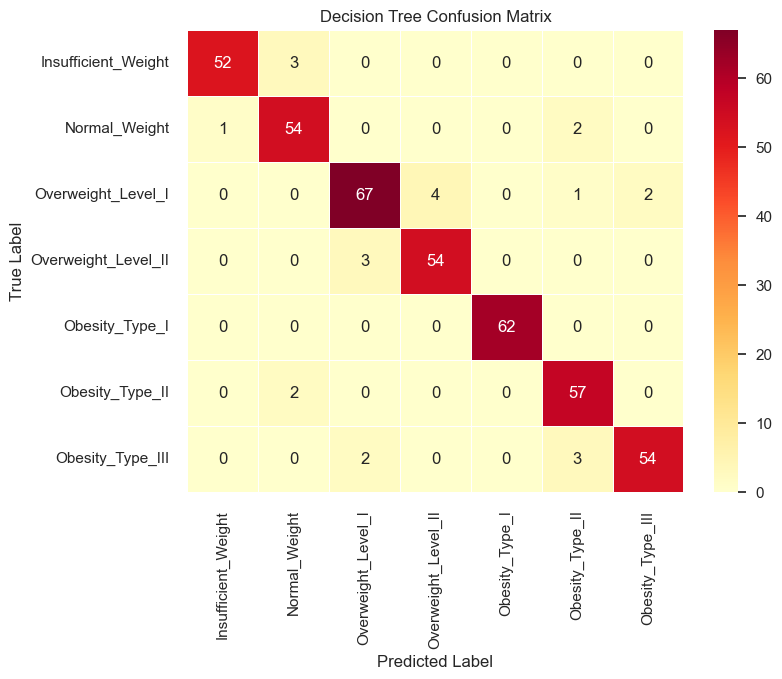

---------------------------------------------------------------------
Random Forest Classifier Accuracy: 0.9527186761229315
Random Forest Training Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.83      0.96      0.89        57
           2       0.96      0.97      0.97        74
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        62
           5       0.96      0.88      0.92        59
           6       0.93      0.90      0.91        59

    accuracy                           0.95       423
   macro avg       0.96      0.95      0.95       423
weighted avg       0.96      0.95      0.95       423



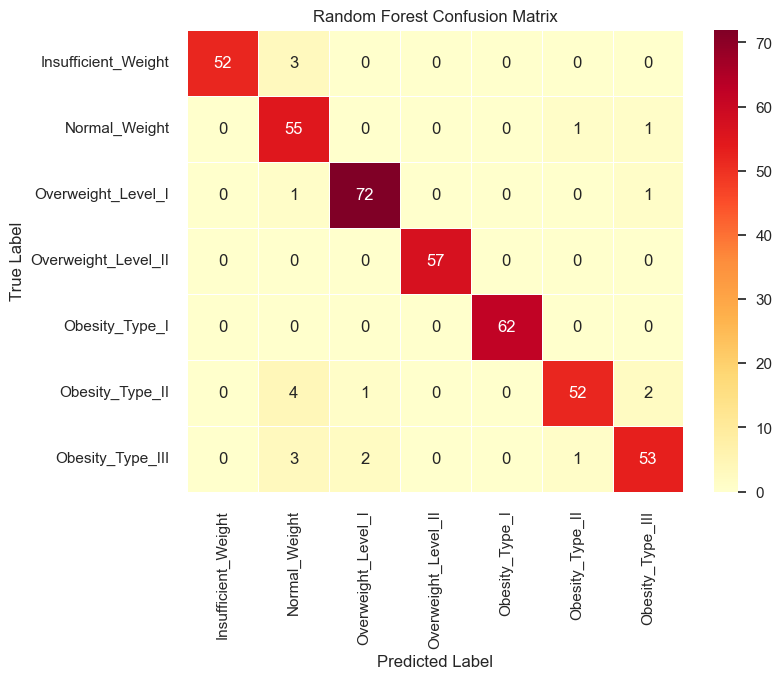

---------------------------------------------------------------------
K-Nearest Neighbor Classifier Accuracy: 0.817966903073286
K-Nearest Neighbor Training Accuracy: 0.909952606635071
K-Nearest Neighbor Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.78        55
           1       0.62      0.37      0.46        57
           2       0.85      0.89      0.87        74
           3       0.90      0.98      0.94        57
           4       1.00      0.97      0.98        62
           5       0.82      0.76      0.79        59
           6       0.80      0.80      0.80        59

    accuracy                           0.82       423
   macro avg       0.81      0.81      0.80       423
weighted avg       0.81      0.82      0.81       423



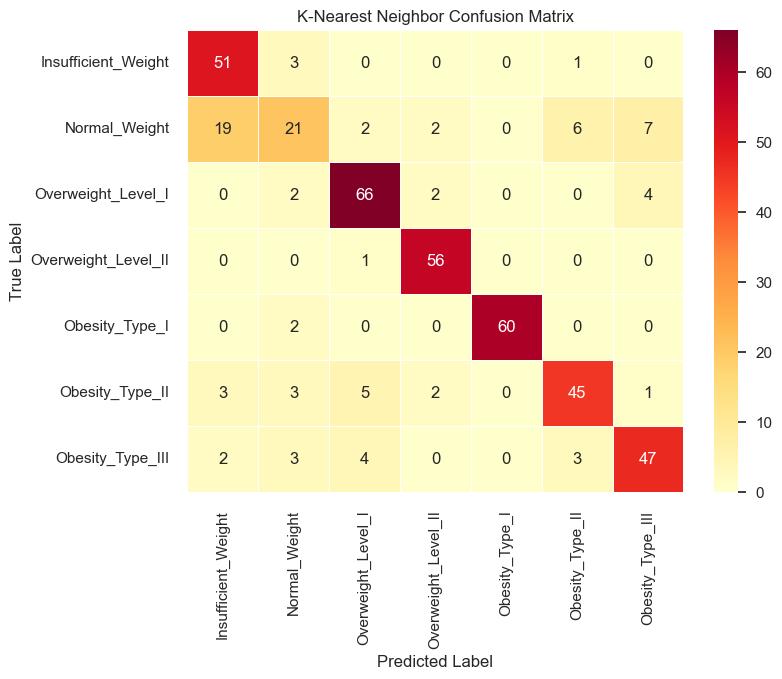

---------------------------------------------------------------------
Support Vector Machine Classifier Accuracy: 0.9550827423167849
Support Vector Machine Training Accuracy: 0.9614928909952607
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        55
           1       0.98      0.82      0.90        57
           2       0.99      0.96      0.97        74
           3       0.93      1.00      0.97        57
           4       1.00      0.98      0.99        62
           5       0.91      0.98      0.94        59
           6       1.00      0.93      0.96        59

    accuracy                           0.96       423
   macro avg       0.96      0.95      0.95       423
weighted avg       0.96      0.96      0.95       423



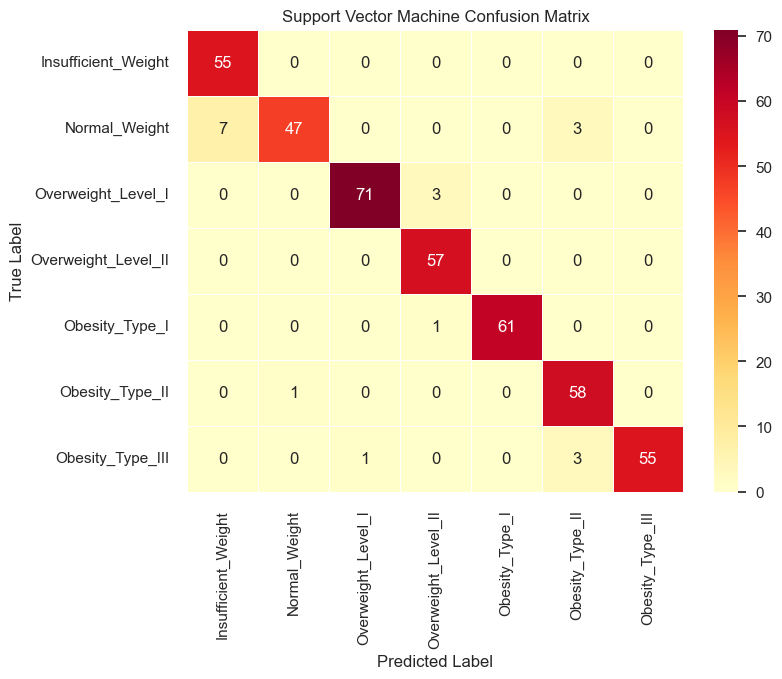

---------------------------------------------------------------------


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi-Layer Perceptron Classifier Accuracy: 0.9385342789598109
Multi-Layer Perceptron Training Accuracy: 0.9994075829383886
Multi-Layer Perceptron Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94        55
           1       0.89      0.89      0.89        57
           2       0.95      0.97      0.96        74
           3       0.97      1.00      0.98        57
           4       1.00      0.97      0.98        62
           5       0.87      0.93      0.90        59
           6       0.98      0.83      0.90        59

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.94      0.94      0.94       423



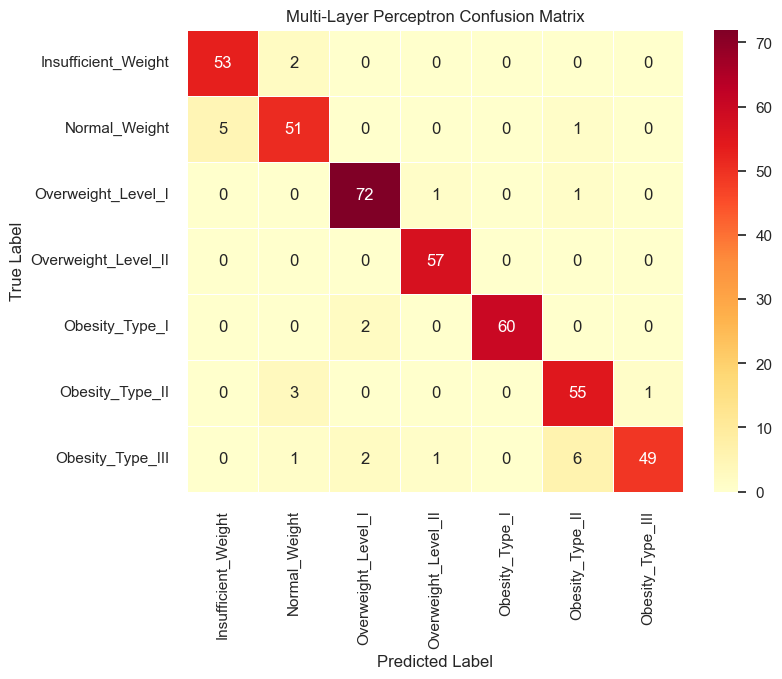

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.9858156028368794
XGBoost Training Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.97      0.98      0.97        57
           2       1.00      1.00      1.00        74
           3       0.98      1.00      0.99        57
           4       1.00      0.98      0.99        62
           5       0.98      0.95      0.97        59
           6       0.98      0.98      0.98        59

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



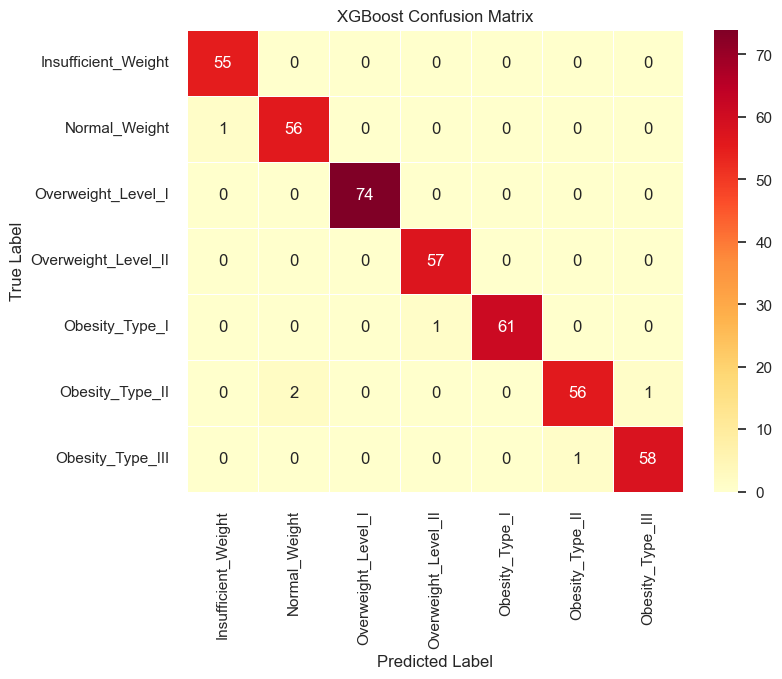

---------------------------------------------------------------------


In [304]:
DT_classifier = DecisionTreeClassifier(random_state=19)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
svm_classifier = SVC(kernel='linear', random_state=19)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,),
                            max_iter=400, activation='relu',
                            learning_rate_init=0.001,
                            solver='adam', random_state=19)
XGB_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=19)
RF_classifier = RandomForestClassifier(n_estimators=100,random_state=19)

classifier = {
    'Decision Tree': DT_classifier,
    'Random Forest':RF_classifier,
    'K-Nearest Neighbor': knn_classifier,
    'Support Vector Machine': svm_classifier,
    'Multi-Layer Perceptron': mlp_classifier,
    'XGBoost':XGB_classifier
}

accuracy_all = evaluate_classifiers(classifier, X_train_1, Y_train, X_test_1, Y_test, sorted_labels)

In [305]:
print(accuracy_all)

{'Decision Tree_Accuracy': 0.9456264775413712, 'Random Forest_Accuracy': 0.9527186761229315, 'K-Nearest Neighbor_Accuracy': 0.817966903073286, 'Support Vector Machine_Accuracy': 0.9550827423167849, 'Multi-Layer Perceptron_Accuracy': 0.9385342789598109, 'XGBoost_Accuracy': 0.9858156028368794}


# Feature Selection

## Variance Threshold (Filter Method)


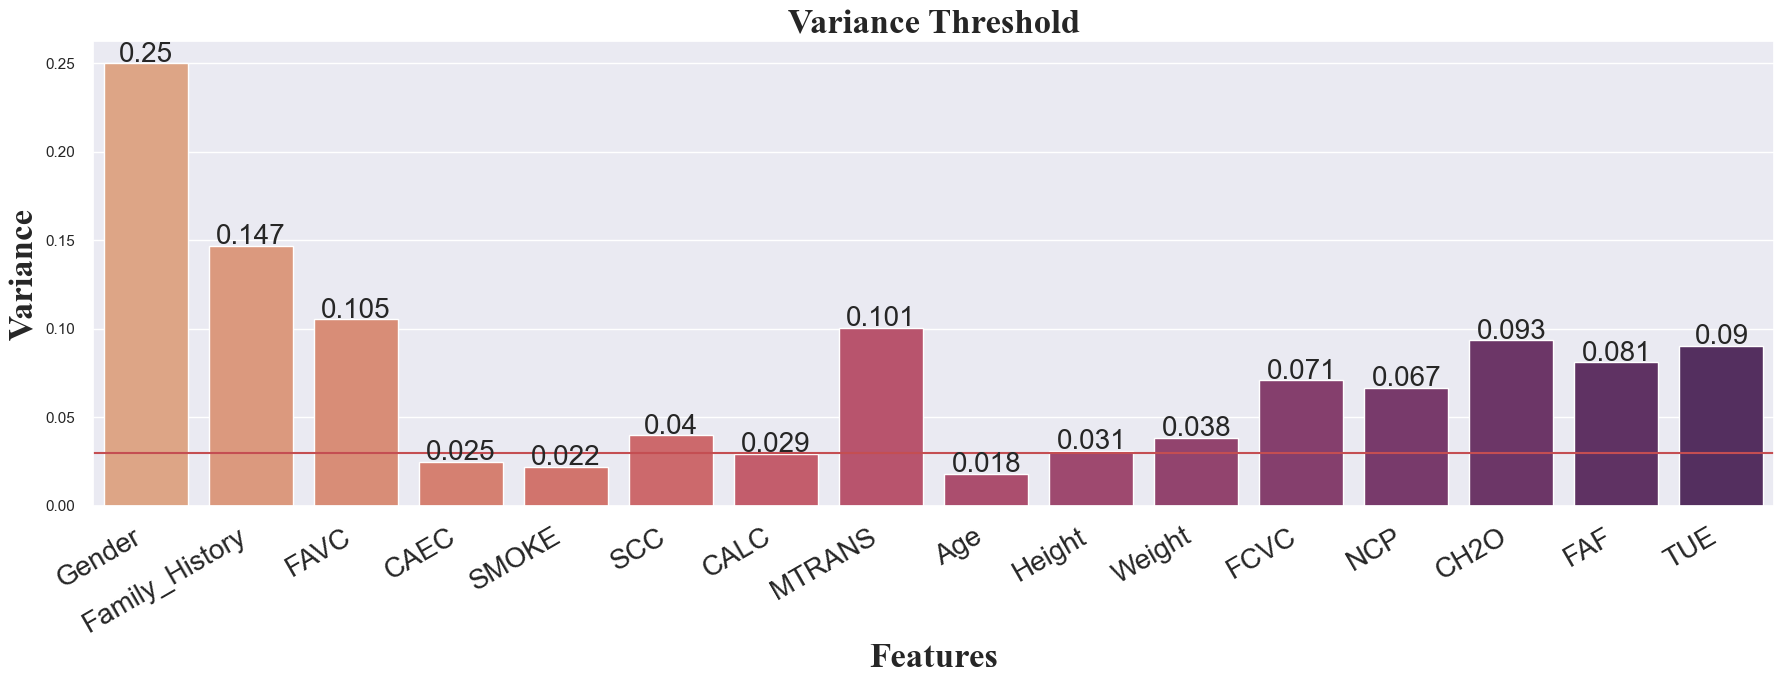

In [260]:
X_train_v1, X_test_v1, Y_train_v1, Y_test_v1 = X_train.copy(), X_test.copy(), Y_train.copy(), Y_test.copy()
X_train_v1.var(axis=0)

scaler = MinMaxScaler()
scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

fig, ax = plt.subplots(figsize=(18,7))

x = X_train_v1.columns
y = scaled_X_train_v1.var(axis=0)

sns.barplot(x=x, y=y, ax=ax, palette='flare')
ax.set_title('Variance Threshold', size=25, family='Times New Roman', weight='bold')
ax.set_xlabel('Features', size=25, family='Times New Roman', weight='bold')
ax.set_ylabel('Variance', size=25, family='Times New Roman', weight='bold')


for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value,3)),ha='center',size=20)
plt.axhline(y=0.03, color='r', linestyle='-')
plt.xticks(rotation=45, ha="right", fontsize=20)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

#### Threshold 0.03 (Removing groups of feauture that falls below threshold)

In [261]:
sel_X_train_v1 = X_train_v1.drop(['Age','CAEC','SMOKE','CALC'], axis = 1)
sel_X_test_v1 = X_test_v1.drop(['Age','CAEC','SMOKE','CALC'], axis = 1)

DT_classifier.fit(sel_X_train_v1,Y_train_v1)

var_preds_DT = DT_classifier.predict(sel_X_test_v1)


### Evaluation after variance feature selection

In [262]:
print("Decision Tree Classifier Accuracy after Variance Selection:",
      accuracy_score(Y_test_v1, var_preds_DT))
print(confusion_matrix(Y_test_v1, var_preds_DT))
print(classification_report(Y_test_v1, var_preds_DT))
training_accuracy = DT_classifier.score(sel_X_train_v1, Y_train_v1)
print("Training Accuracy:", training_accuracy)

accuracy_score_var_DT = round(accuracy_score(Y_test_v1, var_preds_DT),4)
print('Accuracy_score:',accuracy_score_var_DT)

Decision Tree Classifier Accuracy after Variance Selection: 0.9385342789598109
[[52  3  0  0  0  0  0]
 [ 1 55  0  0  0  1  0]
 [ 0  0 72  1  0  0  1]
 [ 0  0  2 55  0  0  0]
 [ 0  0  0  0 62  0  0]
 [ 0 10  0  0  0 49  0]
 [ 0  0  2  0  0  5 52]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.81      0.96      0.88        57
           2       0.95      0.97      0.96        74
           3       0.98      0.96      0.97        57
           4       1.00      1.00      1.00        62
           5       0.89      0.83      0.86        59
           6       0.98      0.88      0.93        59

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.94      0.94      0.94       423

Training Accuracy: 1.0
Accuracy_score: 0.9385


##### Plot Comparison of accuracy between features after selection

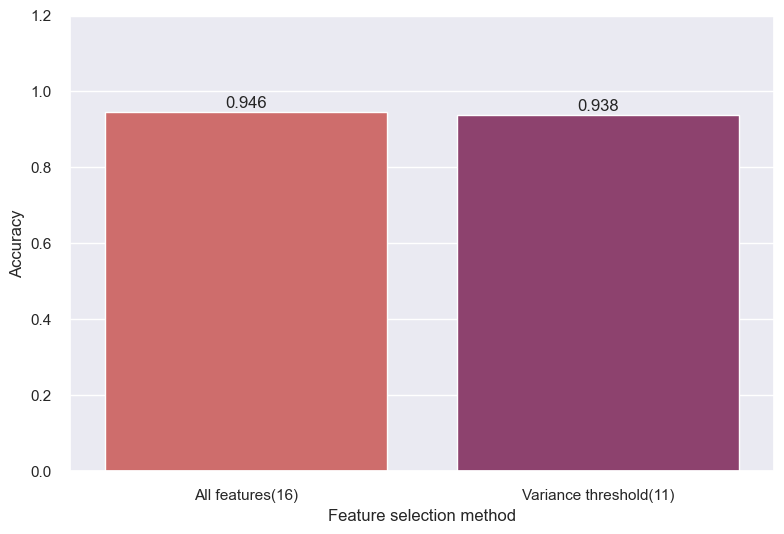

In [263]:
fig, ax = plt.subplots()

x = ['All features(16)', 'Variance threshold(11)']
y = [accuracy_all['Decision Tree_Accuracy'], accuracy_score_var_DT]

sns.barplot(x=x, y=y, ax=ax, palette='flare')
ax.set_xlabel('Feature selection method')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.01, s=str(round(value, 3)), ha='center')

plt.tight_layout()
plt.show()

## K-best (Mutual Information) Decision Tree Classifier

In [264]:
# Copy of train and test set
X_train_v2, X_test_v2, Y_train_v2, Y_test_v2 = X_train.copy(), X_test.copy(), Y_train.copy(), Y_test.copy()


In [265]:
accuracy_score_KB = []

for k in range (1,17):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2,Y_train_v2)
    
    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)
    
    DT_classifier.fit(sel_X_train_v2,Y_train_v2)
    kbest_preds = DT_classifier.predict(sel_X_test_v2)
    
    accuracy_kbest = round(f1_score(Y_test_v2,kbest_preds,average= 'weighted'),3)
    
    accuracy_score_KB.append(accuracy_kbest)

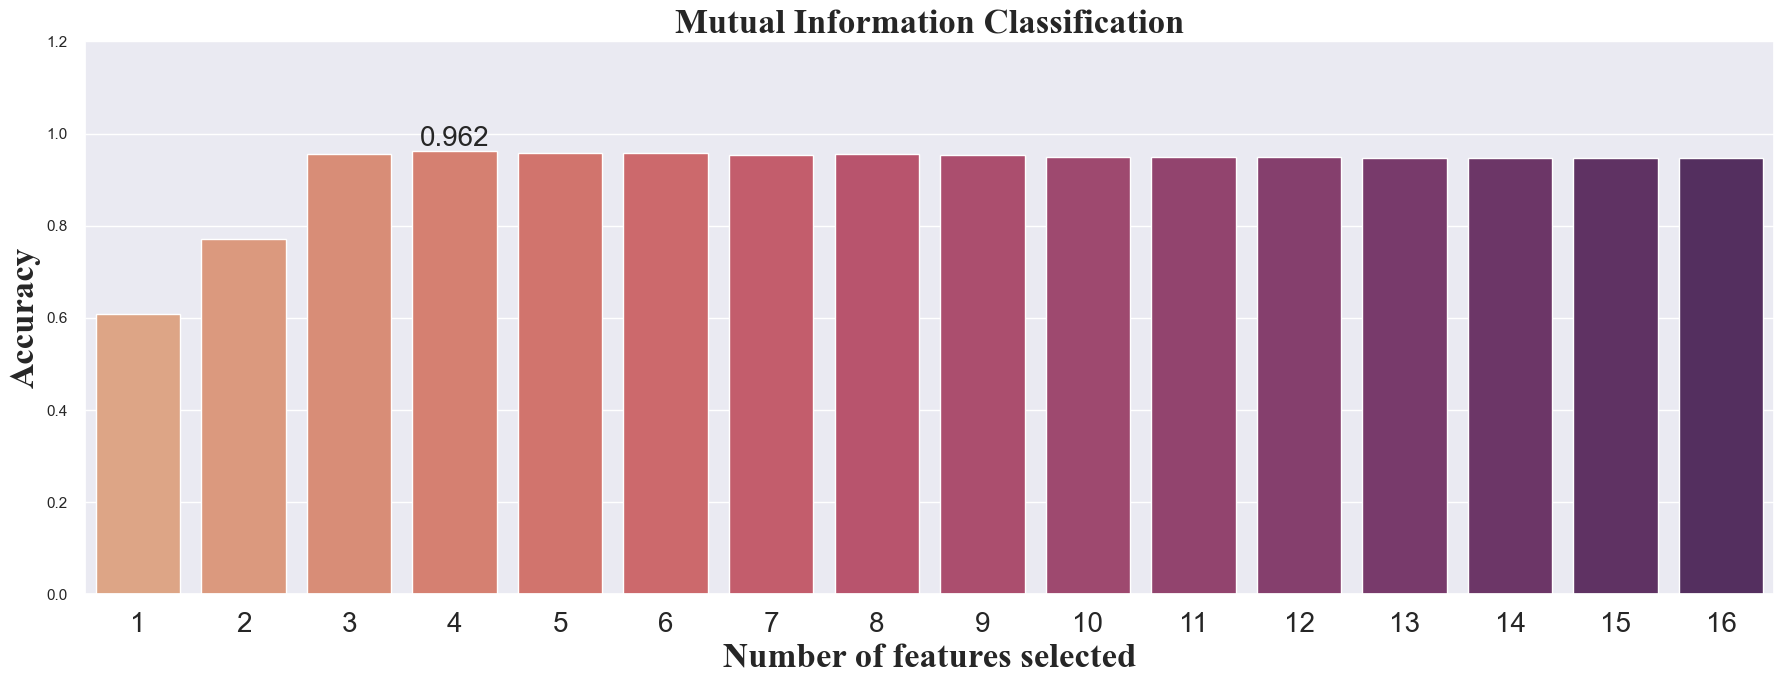

In [266]:
fig, ax = plt.subplots(figsize=(18,7))

x = np.arange(1,17)
y = accuracy_score_KB

sns.barplot(x=x, y=y, ax=ax, palette='flare')
ax.set_title('Mutual Information Classification', size=25, family='Times New Roman', weight='bold')
ax.set_xlabel('Number of features selected', size=25, family='Times New Roman', weight='bold')
ax.set_ylabel('Accuracy', size=25, family='Times New Roman', weight='bold')
ax.set_ylim(0,1.2)
ax.set_xticks(np.arange(0,16))
ax.set_xticklabels(np.arange(1,17),fontsize=20)

# Find the index of the maximum Accuracy score point
max_ac_index = np.argmax(y)
max_ac_value_KB = y[max_f1_index]

# Annotate only the highest point
plt.text(x=max_ac_index , y=max_ac_value_KB + 0.01, s=str(round(max_ac_value_KB, 3)), ha='center',size = 20)

plt.tight_layout()
plt.show()

##### Check which is the features that were selected based on the number

In [267]:
selector = SelectKBest(mutual_info_classif,k=4)
selector.fit(X_train_v2, Y_train_v2)

selected_feature_mask = selector.get_support()
selected_features_KB = X_train_v2.columns[selected_feature_mask]
selected_features_KB

Index(['Age', 'Height', 'Weight', 'FCVC'], dtype='object')

### Summarize of accuracy score by all feature selection methods

0.9456 0.9385 0.962


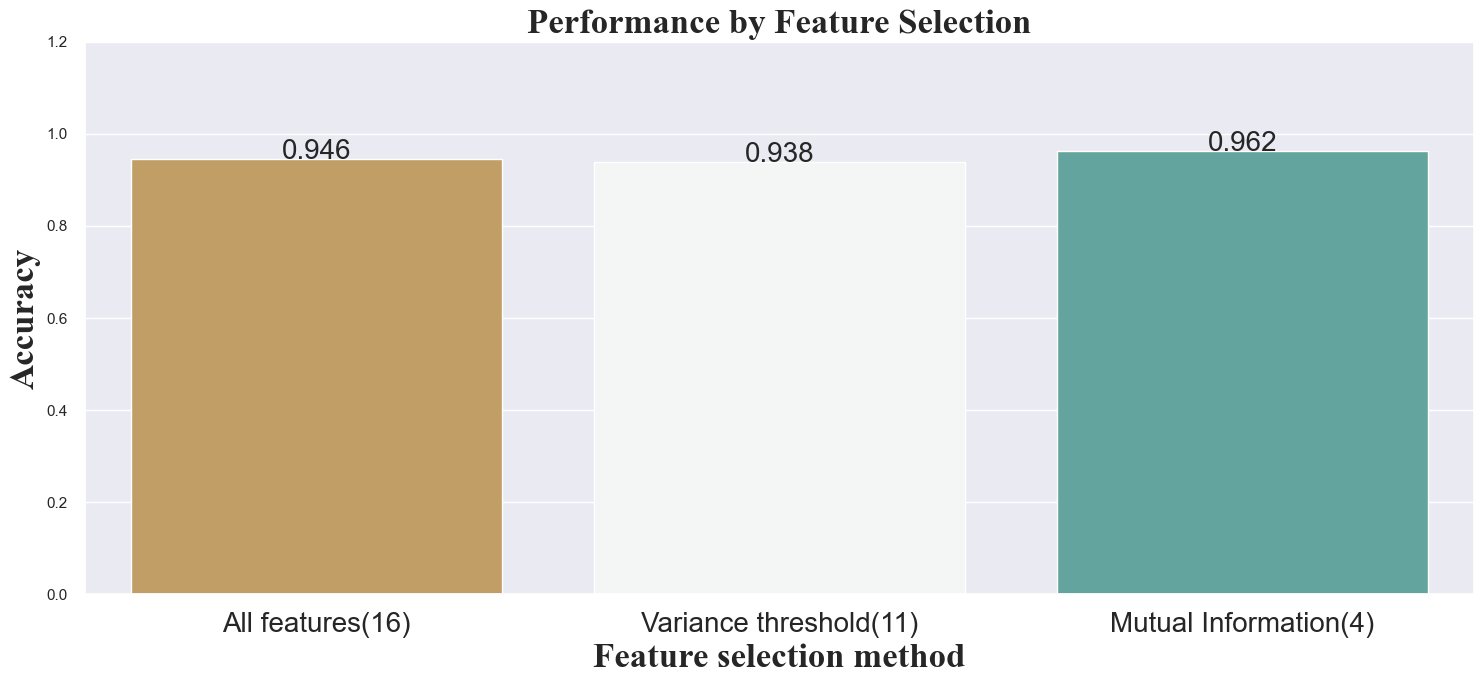

In [306]:
print(round(accuracy_all['Decision Tree_Accuracy'],accuracy_score_var_DT,max_ac_value_KB)
fig, ax = plt.subplots(figsize=(15,7))

x = ['All features(16)','Variance threshold(11)','Mutual Information(4)']
y = [accuracy_all['Decision Tree_Accuracy'],accuracy_score_var_DT,max_ac_value_KB]

sns.barplot(x=x, y=y, ax=ax, palette='BrBG')
ax.set_title('Performance by Feature Selection', size=25, family='Times New Roman', weight='bold')
ax.set_xlabel('Feature selection method', size=25, family='Times New Roman', weight='bold')
ax.set_ylabel('Accuracy', size=25, family='Times New Roman', weight='bold')
ax.set_ylim(0,1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value, s=str(round(value,3)),ha='center',size=20)

plt.xticks(ha="center", fontsize=20)
plt.tight_layout()
plt.show()

### Apply data after feature selection to model

In [269]:
#Selected Features
print('Select:',selected_features_KB)

# All feature names
print(Ob.columns)

Select: Index(['Age', 'Height', 'Weight', 'FCVC'], dtype='object')
Index(['Gender', 'Age', 'Height', 'Weight', 'Family_History', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'NObeyesdad'],
      dtype='object')


In [270]:
# Applied selected feature to X,Y dataset
X_FS,Y_FS = X.copy(),Y.copy()

X_FS = X_FS.drop(['Gender', 'Family_History', 'FAVC', 'NCP', 'CAEC', 'SMOKE',
                  'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'], axis = 1)

In [271]:
# Split Data for training and test sets
X_train_FS , X_test_FS , Y_train_FS , Y_test_FS = train_test_split(X_FS, Y_FS,test_size = 0.20,random_state = 19)

# Model Training, Testing and Evaluation

## Scaling 

In [274]:
# Scaling is important for KNN and SVM as they are sensitive to the magnitude of the features
scaler = StandardScaler()
X_train_FS = scaler.fit_transform(X_train_FS)
X_test_FS = scaler.transform(X_test_FS)

Decision Tree Classifier Accuracy: 0.9621749408983451
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.96      0.96      0.96        57
           2       0.93      0.96      0.95        74
           3       0.98      0.95      0.96        57
           4       0.98      0.98      0.98        62
           5       0.93      0.97      0.95        59
           6       0.96      0.92      0.94        59

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423

Decision Tree Training Accuracy: 1.0


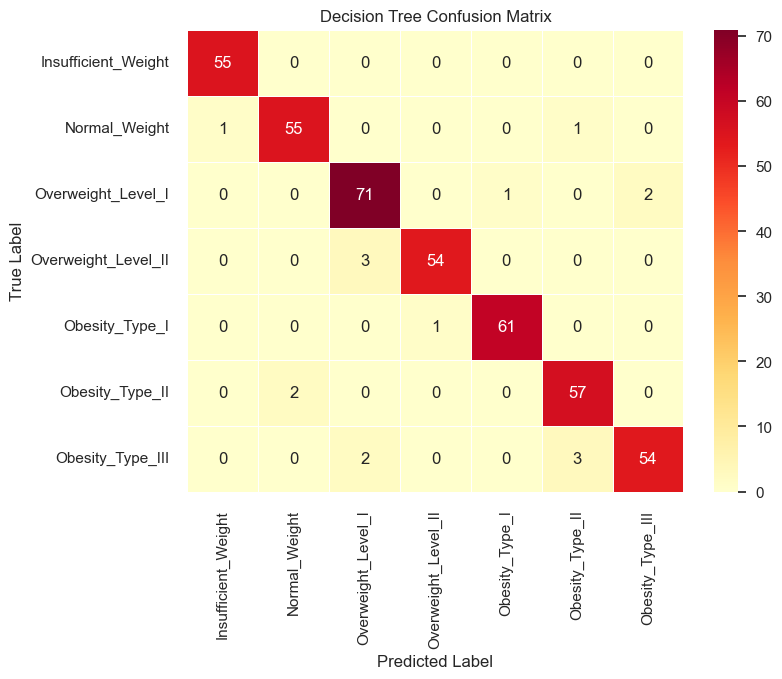

---------------------------------------------------------------------
Random Forest Classifier Accuracy: 0.9858156028368794
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.98      0.96      0.97        57
           2       0.99      0.99      0.99        74
           3       1.00      0.98      0.99        57
           4       0.98      1.00      0.99        62
           5       0.97      0.97      0.97        59
           6       0.98      1.00      0.99        59

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423

Random Forest Training Accuracy: 1.0


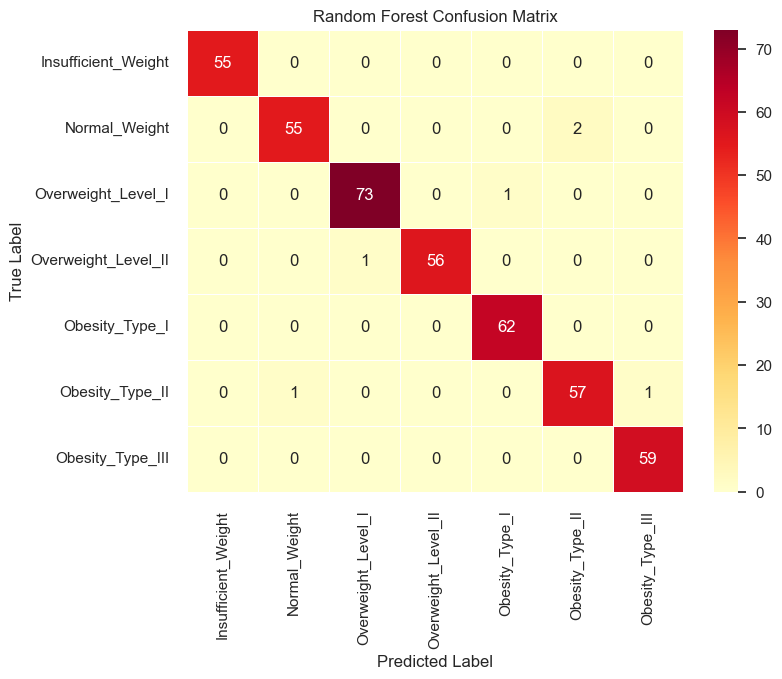

---------------------------------------------------------------------
K-Nearest Neighbor Classifier Accuracy: 0.9385342789598109
K-Nearest Neighbor Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       0.94      0.88      0.91        57
           2       0.95      0.95      0.95        74
           3       1.00      0.98      0.99        57
           4       0.98      1.00      0.99        62
           5       0.90      0.88      0.89        59
           6       0.84      0.88      0.86        59

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.94      0.94      0.94       423

K-Nearest Neighbor Training Accuracy: 0.9579383886255924


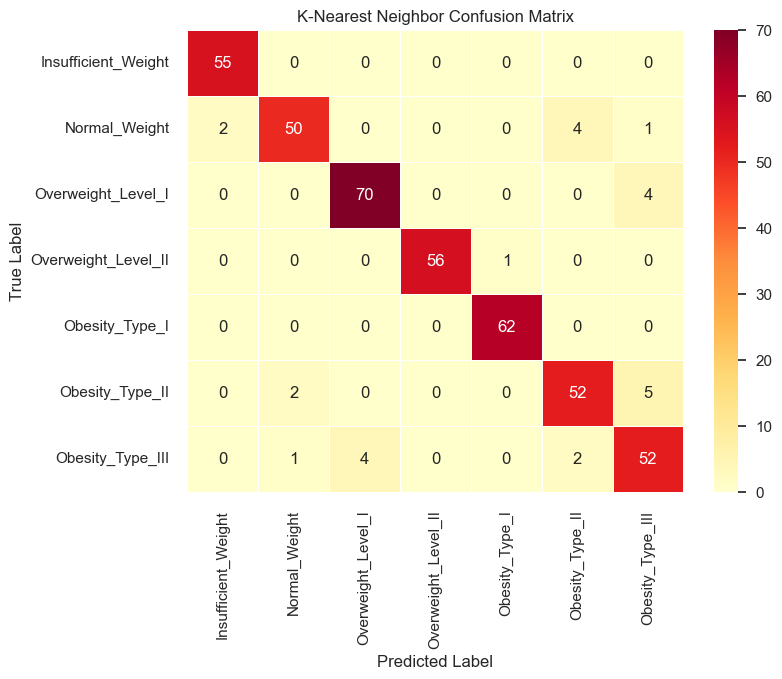

---------------------------------------------------------------------
Support Vector Machine Classifier Accuracy: 0.9408983451536643
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        55
           1       1.00      0.81      0.89        57
           2       0.99      0.96      0.97        74
           3       0.98      0.89      0.94        57
           4       0.91      1.00      0.95        62
           5       0.88      1.00      0.94        59
           6       0.96      0.92      0.94        59

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.94      0.94       423

Support Vector Machine Training Accuracy: 0.9419431279620853


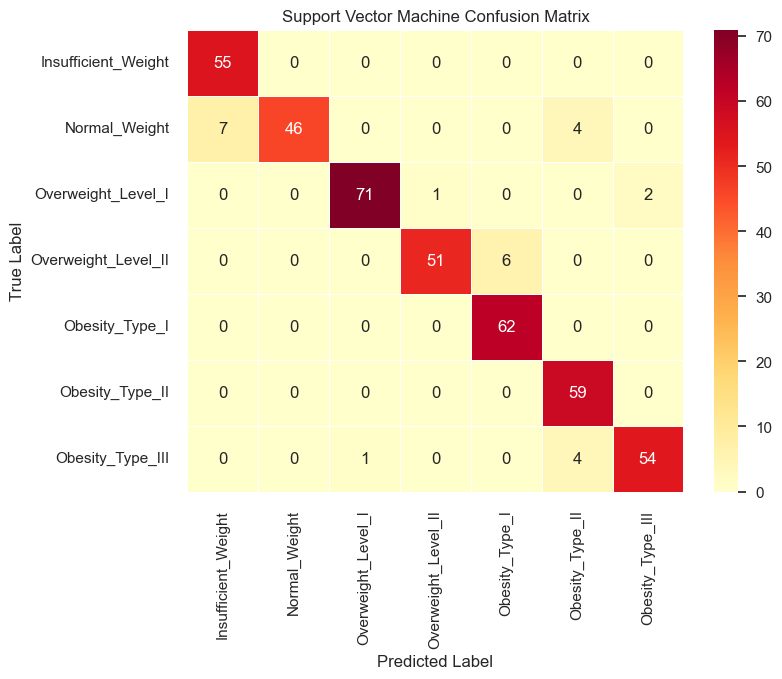

---------------------------------------------------------------------


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi-Layer Perceptron Classifier Accuracy: 0.9739952718676123
Multi-Layer Perceptron Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        55
           1       1.00      0.91      0.95        57
           2       1.00      0.97      0.99        74
           3       0.98      0.96      0.97        57
           4       0.97      1.00      0.98        62
           5       0.95      1.00      0.98        59
           6       0.98      0.97      0.97        59

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.98      0.97      0.97       423

Multi-Layer Perceptron Training Accuracy: 0.9757109004739336


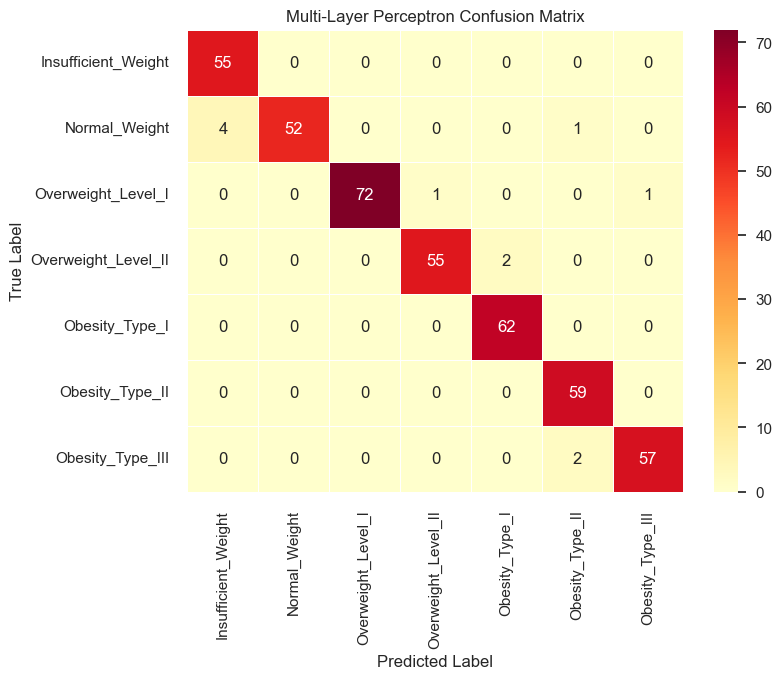

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.983451536643026
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.98      1.00      0.99        57
           2       1.00      1.00      1.00        74
           3       0.98      0.98      0.98        57
           4       0.98      0.98      0.98        62
           5       0.94      0.98      0.96        59
           6       1.00      0.93      0.96        59

    accuracy                           0.98       423
   macro avg       0.98      0.98      0.98       423
weighted avg       0.98      0.98      0.98       423

XGBoost Training Accuracy: 1.0


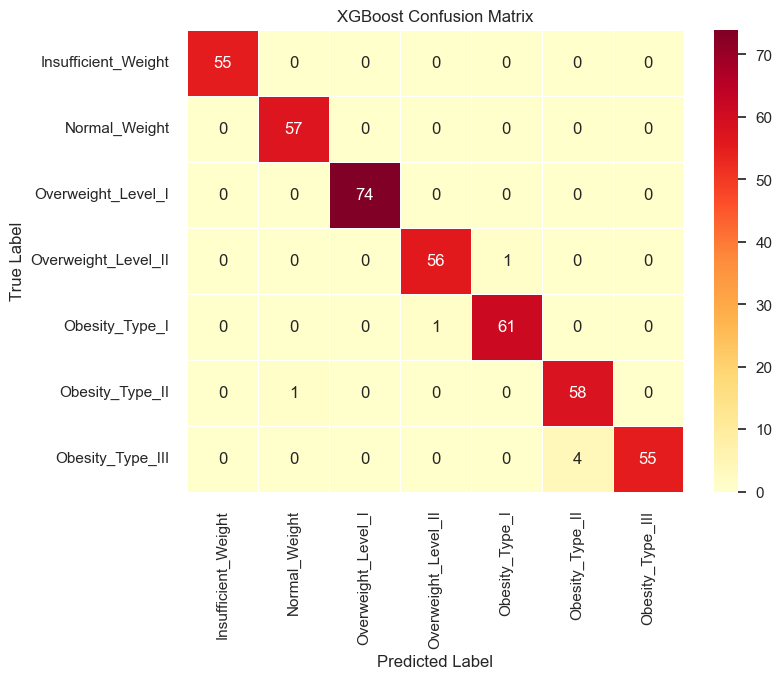

---------------------------------------------------------------------


In [275]:
DT_classifier = DecisionTreeClassifier(random_state=19)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
svm_classifier = SVC(kernel='linear', random_state=19)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,),
                            max_iter=400, activation='relu',
                            learning_rate_init=0.001,
                            solver='adam', random_state=19)
XGB_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=19)
RF_classifier = RandomForestClassifier(n_estimators=100,random_state=19)

classifier = {
    'Decision Tree': DT_classifier,
    'Random Forest':RF_classifier,
    'K-Nearest Neighbor': knn_classifier,
    'Support Vector Machine': svm_classifier,
    'Multi-Layer Perceptron': mlp_classifier,
    'XGBoost':XGB_classifier
}

accuracy_4_FS = evaluate_classifiers(classifier, X_train_FS, Y_train_FS, X_test_FS, Y_test_FS, sorted_labels)

In [276]:
print(accuracy_4_FS)

{'Decision Tree_Accuracy': 0.9621749408983451, 'Random Forest_Accuracy': 0.9858156028368794, 'K-Nearest Neighbor_Accuracy': 0.9385342789598109, 'Support Vector Machine_Accuracy': 0.9408983451536643, 'Multi-Layer Perceptron_Accuracy': 0.9739952718676123, 'XGBoost_Accuracy': 0.983451536643026}


# Summary of accuracy by Machine Learning Models

In [277]:
acc_DT = accuracy_4_FS['Decision Tree_Accuracy']
acc_knn = accuracy_4_FS['K-Nearest Neighbor_Accuracy']
acc_svm = accuracy_4_FS['Support Vector Machine_Accuracy']
acc_mlp = accuracy_4_FS['Multi-Layer Perceptron_Accuracy']
acc_Xgb = accuracy_4_FS['XGBoost_Accuracy']
acc_rf = accuracy_4_FS['Random Forest_Accuracy']

In [278]:
print(acc_DT,acc_knn,acc_svm,acc_mlp,acc_Xgb,acc_rf)

0.9621749408983451 0.9385342789598109 0.9408983451536643 0.9739952718676123 0.983451536643026 0.9858156028368794


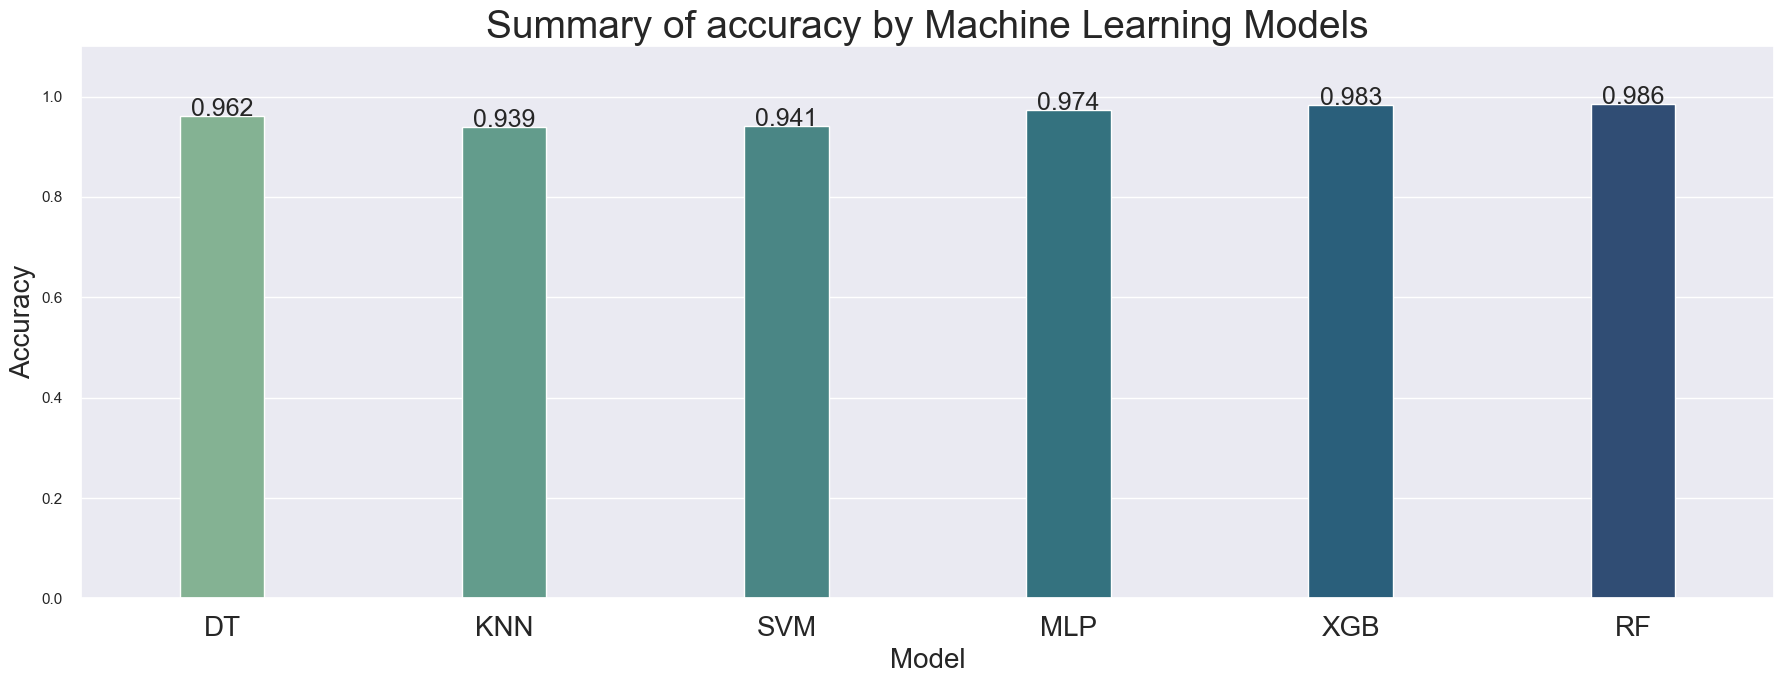

In [279]:
fig, ax = plt.subplots(figsize=(18,7))

x = ['DT','KNN','SVM','MLP','XGB','RF']
y = [acc_DT,acc_knn,acc_svm,acc_mlp,acc_Xgb,acc_rf]

sns.barplot(x=x, y=y, ax=ax,width =0.3, palette='crest')
ax.set_xlabel('Model',fontsize=20)
ax.set_xticklabels(x, fontsize= 20)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_title('Summary of accuracy by Machine Learning Models', fontsize=28)

ax.set_ylim(0,1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value, s=str(round(value,3)),ha='center',size = 18)

plt.tight_layout()
plt.show()

## Cross Validation

In [280]:
def evaluate_cross_val_score(models, X_train, Y_train, results, cv=10, scoring='accuracy'):
    """
    Evaluate models performance using cross-validation.
    
    """
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring)
        results[model_name] = scores.mean()

    return results

results = {}

models_1 = {
    'Decision Tree': DT_classifier,
    'Random Forest':RF_classifier,
    'K-Nearest Neighbor': knn_classifier,
    'Support Vector Machine': svm_classifier,
    'Multi-Layer Perceptron': mlp_classifier,
    'XGBoost':XGB_classifier
}

# Run Function
results = evaluate_cross_val_score(models_1, X_train_FS, Y_train_FS,results)

# Print results
for model_name, score in results.items():
    print(f"{model_name}: {score}")

C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer

Decision Tree: 0.9419378698224852
Random Forest: 0.9615138067061144
K-Nearest Neighbor: 0.9004754860524091
Support Vector Machine: 0.9336573682727527
Multi-Layer Perceptron: 0.9615032403493939
XGBoost: 0.9603198083967316


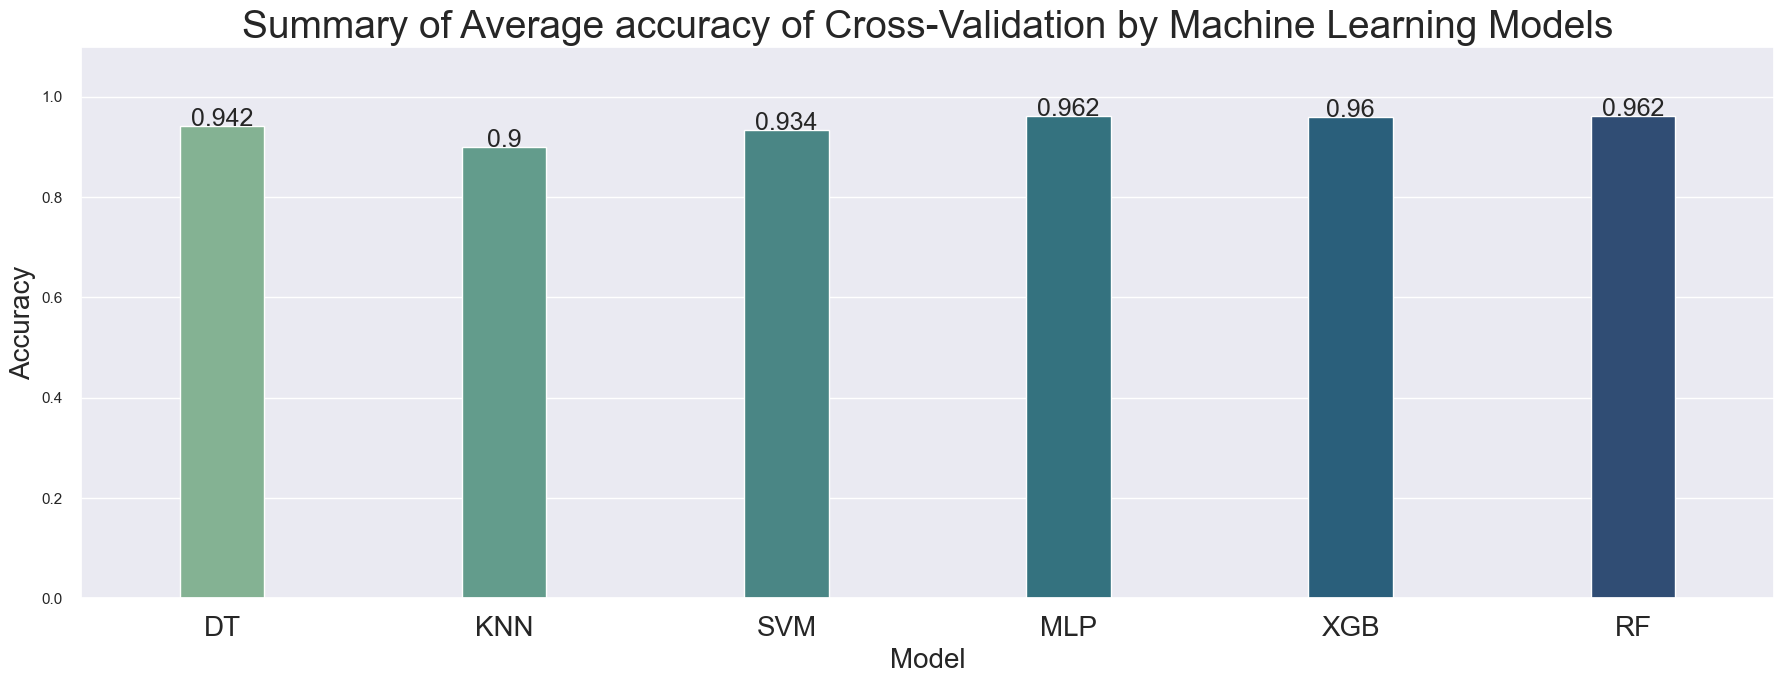

In [281]:
fig, ax = plt.subplots(figsize=(18,7))

x = ['DT','KNN','SVM','MLP','XGB','RF']
y = [results['Decision Tree'],results['K-Nearest Neighbor'],results['Support Vector Machine'],
     results['Multi-Layer Perceptron'],results['XGBoost'],results['Random Forest']]

sns.barplot(x=x, y=y, ax=ax,width =0.3, palette='crest')
ax.set_xlabel('Model',fontsize=20)
ax.set_xticklabels(x, fontsize= 20)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_title('Summary of Average accuracy of Cross-Validation by Machine Learning Models', fontsize=28)

ax.set_ylim(0,1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value, s=str(round(value,3)),ha='center',size = 18)

plt.tight_layout()
plt.show()

#  HYPERPARAMETER TUNING GRID SEARCH

In [247]:
def evaluate_model_with_gridsearch(model, param_grid, X, y):
    """
    Performs GridSearchCV on the given model and parameter grid, plots training and testing scores

    """
    # Perform grid search 
    GS = GridSearchCV(model, param_grid, cv=10, return_train_score=True, n_jobs=-1)
    GS.fit(X, y)
    
    # Best parameters and estimator
    print("Best Parameters:", GS.best_params_)
    print(f"Test Accuracy Score for Best Parameters: {GS.best_score_:.4f}")
    
    # Extract train and test accuracy scores
    train_accuracy_scores = GS.cv_results_['mean_train_score']
    test_accuracy_scores = GS.cv_results_['mean_test_score']
    
    # Generate the parameter value labels
    param_keys = list(param_grid.keys())
    param_values = [str(d[param_keys[0]]) for d in GS.cv_results_['params']]
    
    # Plotting both Training and Testing Scores
    plt.figure(figsize=(12, 6))
    plt.plot(param_values, train_accuracy_scores, marker='o', linestyle='-', color='r', label='Training Score')
    plt.plot(param_values, test_accuracy_scores, marker='o', linestyle='-', color='b', label='Testing Score')
    plt.xlabel(param_keys[0],fontsize = 15)
    plt.ylabel('Accuracy Score',fontsize = 15)
    plt.title(f'Training vs. Testing Performance of {model.__class__.__name__} with Different Parameters', size = 18)
    plt.xticks(ticks=range(len(param_values)), labels=param_values,fontsize = 15)  # Set x-axis labels to parameter values
    plt.legend()
    plt.grid(True)
    plt.show()


Best Parameters: {'criterion': 'entropy'}
Test Accuracy Score for Best Parameters: 0.9564


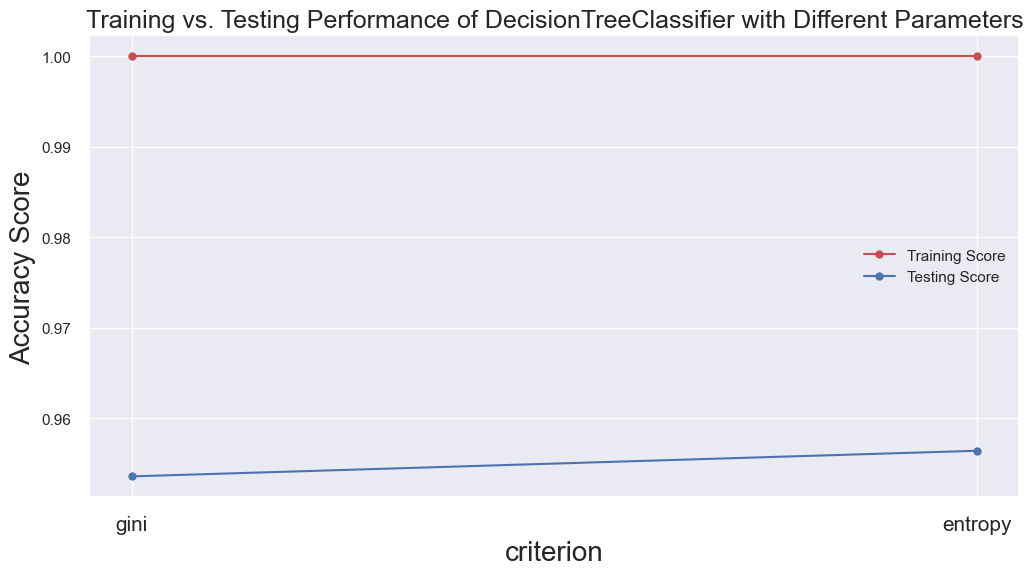

CPU times: total: 125 ms
Wall time: 222 ms


In [246]:
%%time
DT_classifier = DecisionTreeClassifier(random_state=19)

param_DT = {'criterion': ['gini', 'entropy']}

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_FS, Y_FS)


Best Parameters: {'max_depth': 12}
Test Accuracy Score for Best Parameters: 0.9531


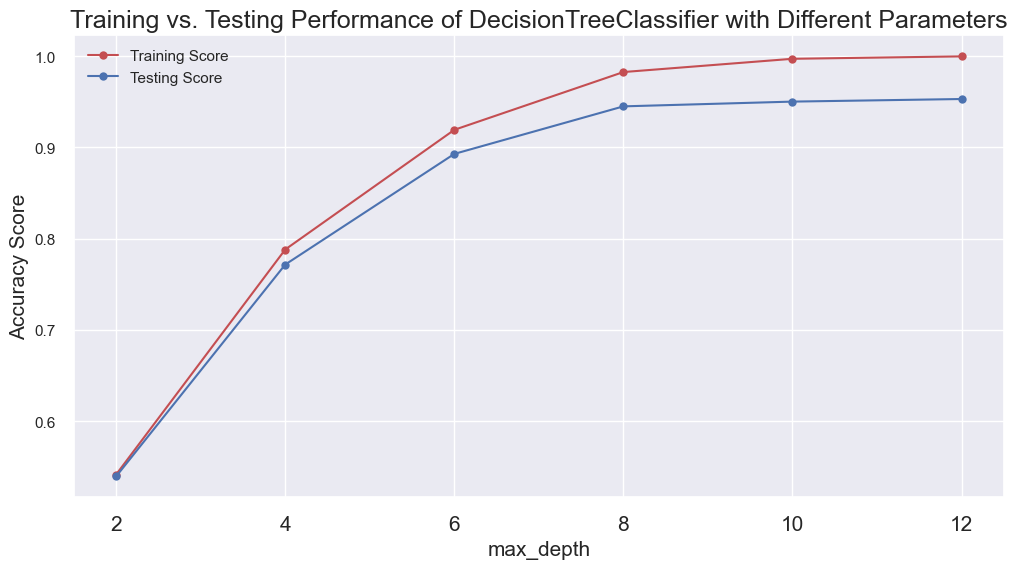

CPU times: total: 156 ms
Wall time: 328 ms


In [248]:
%%time
DT_classifier = DecisionTreeClassifier(random_state=19)

param_DT = {'max_depth': [2, 4, 6, 8, 10, 12]}

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_FS, Y_FS)

param_DT = [{'criterion': ['gini', 'entropy'],
             'max_depth': [2, 4, 6, 8, 10, 12]}]

param_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


Best Parameters: {'n_estimators': 200}
Test Accuracy Score for Best Parameters: 0.9631


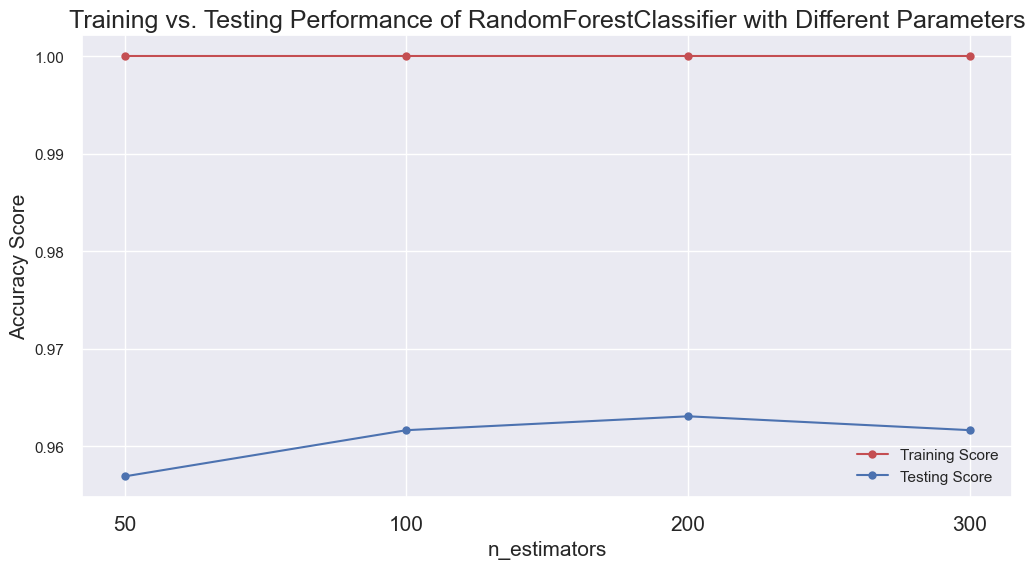

CPU times: total: 2.19 s
Wall time: 5.79 s


In [249]:
%%time
param_RF = {
    'n_estimators': [50, 100, 200, 300]
}

evaluate_model_with_gridsearch(RF_classifier, param_RF, X_FS, Y_FS)

Best Parameters: {'max_depth': 20}
Test Accuracy Score for Best Parameters: 0.9617


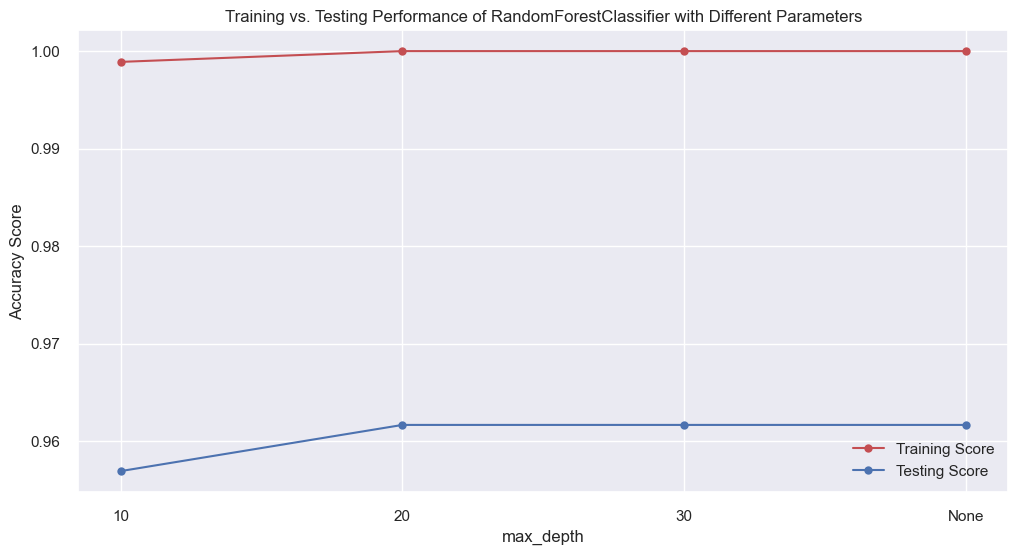

CPU times: total: 1.75 s
Wall time: 3.58 s


In [141]:
%%time
param_RF = {
    'max_depth': [10, 20, 30, None],
}

evaluate_model_with_gridsearch(RF_classifier, param_RF, X_FS, Y_FS)

Best Parameters: {'min_samples_split': 4}
Test Accuracy Score for Best Parameters: 0.9664


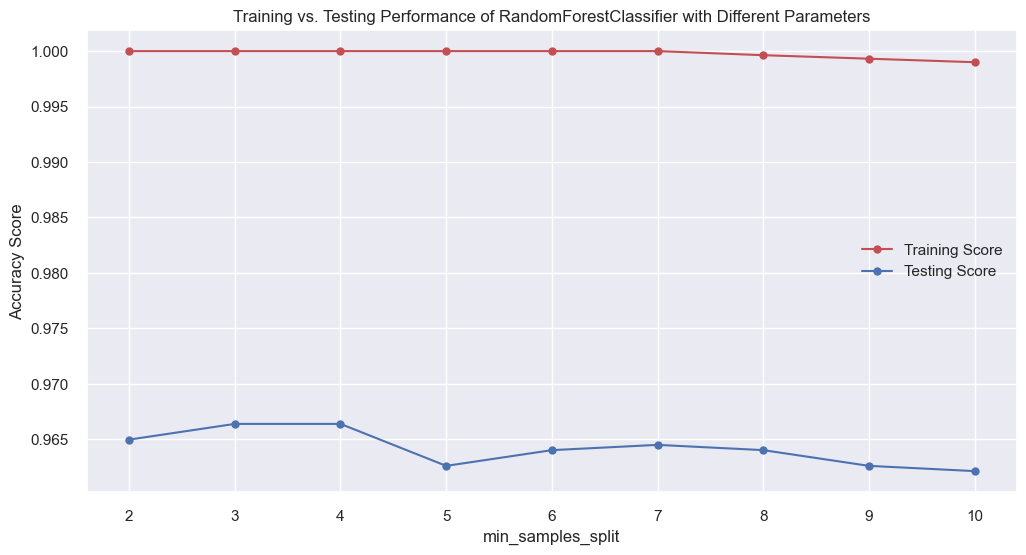

CPU times: total: 7.72 s
Wall time: 19.8 s


In [186]:
%%time
param_RF = {
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}
evaluate_model_with_gridsearch(RF_classifier, param_RF, X_FS, Y_FS)

Best Parameters: {'min_samples_leaf': 1}
Test Accuracy Score for Best Parameters: 0.9617


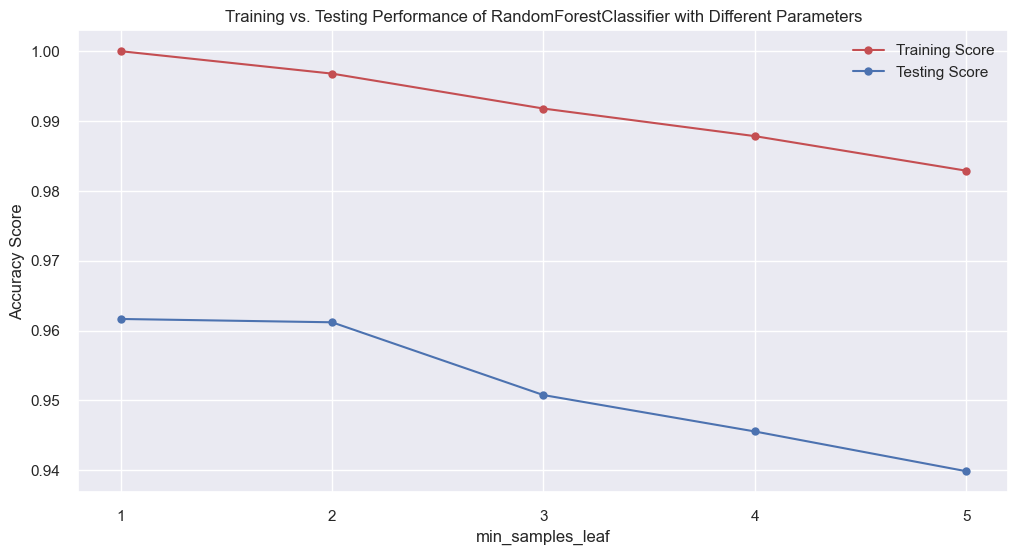

CPU times: total: 2.16 s
Wall time: 4.16 s


In [147]:
%%time
param_RF = {
    'min_samples_leaf': [1, 2, 3, 4, 5],
}
evaluate_model_with_gridsearch(RF_classifier, param_RF, X_FS, Y_FS)

Best Parameters: {'bootstrap': False}
Test Accuracy Score for Best Parameters: 0.9659


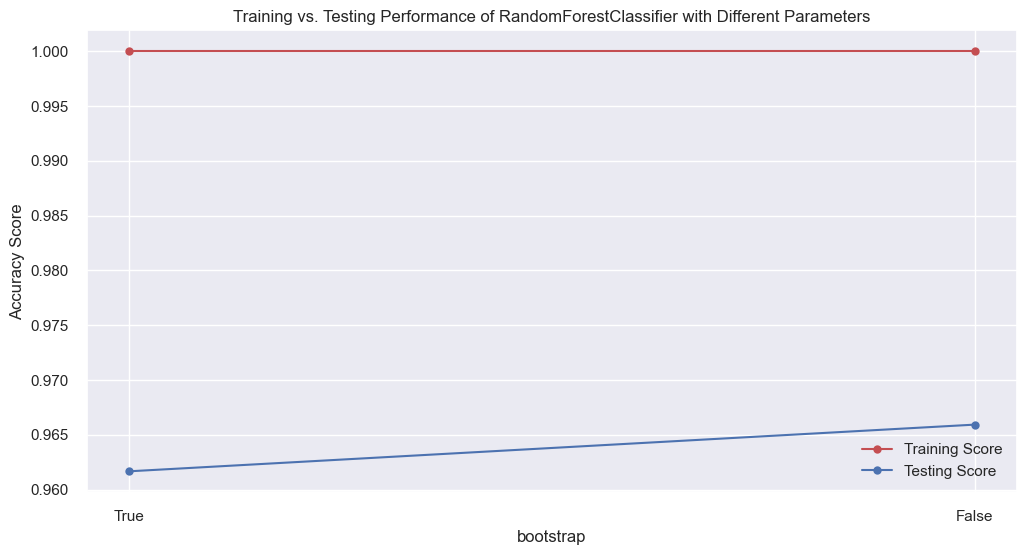

CPU times: total: 1.06 s
Wall time: 2.26 s


In [144]:
%%time
param_RF = {
    'bootstrap': [True, False]
}
evaluate_model_with_gridsearch(RF_classifier, param_RF, X_FS, Y_FS)

param_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

Best Parameters: {'n_neighbors': 3}
Test Accuracy Score for Best Parameters: 0.8262


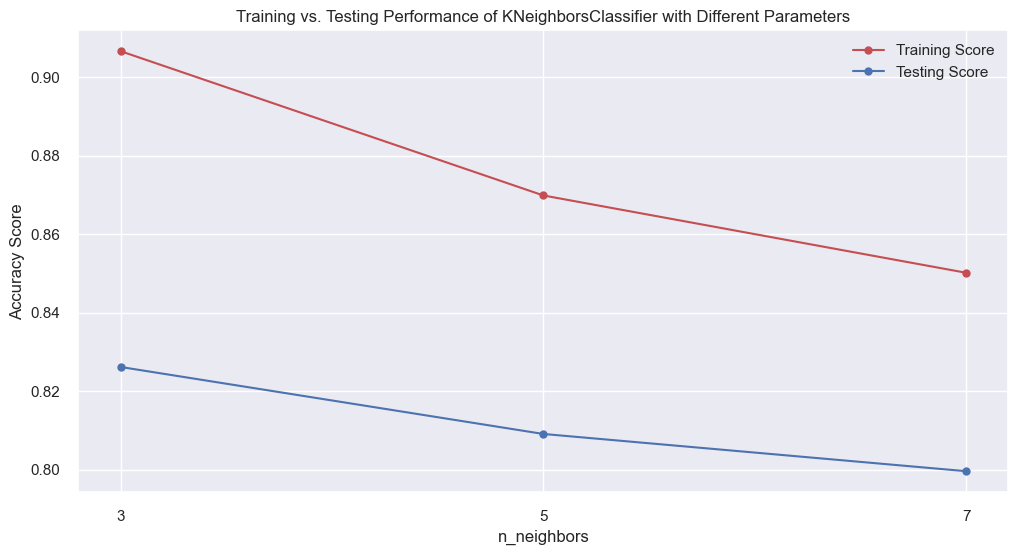

CPU times: total: 172 ms
Wall time: 522 ms


In [154]:
%%time
param_knn = {
    'n_neighbors': [ 3, 5, 7],
}

evaluate_model_with_gridsearch(knn_classifier, param_knn, X_FS, Y_FS)

Best Parameters: {'weights': 'distance'}
Test Accuracy Score for Best Parameters: 0.8375


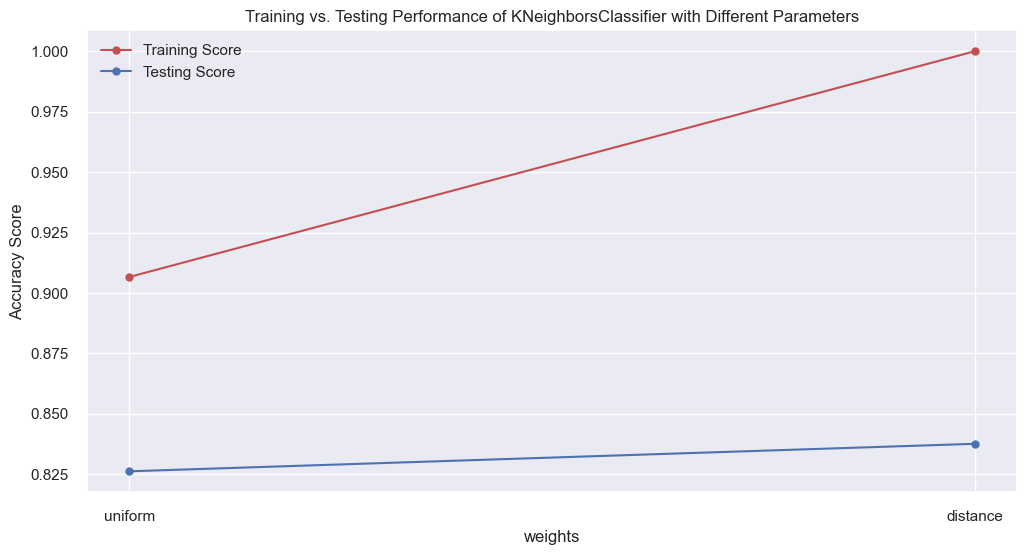

CPU times: total: 156 ms
Wall time: 282 ms


In [150]:
%%time
param_knn = {
    'weights': ['uniform', 'distance'],
}

evaluate_model_with_gridsearch(knn_classifier, param_knn, X_FS, Y_FS)

Best Parameters: {'algorithm': 'auto'}
Test Accuracy Score for Best Parameters: 0.8262


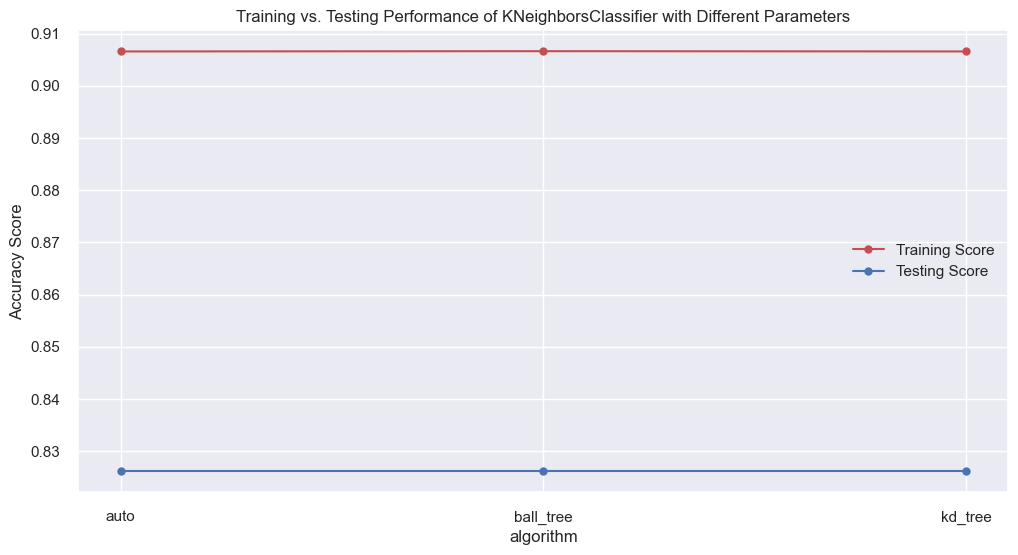

CPU times: total: 125 ms
Wall time: 559 ms


In [151]:
%%time
param_knn = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

evaluate_model_with_gridsearch(knn_classifier, param_knn, X_FS, Y_FS)

param_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

Best Parameters: {'C': 100}
Test Accuracy Score for Best Parameters: 0.9583


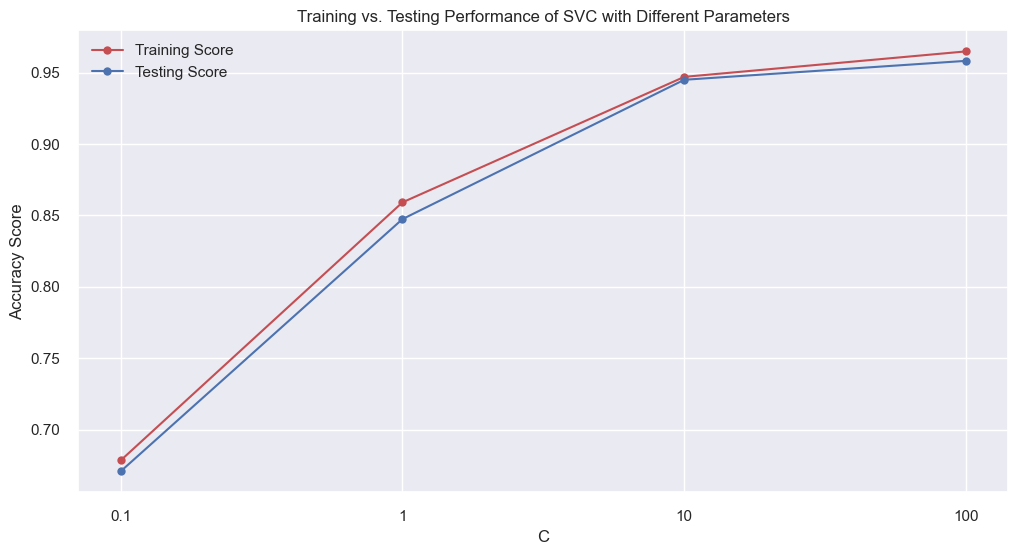

CPU times: total: 2.44 s
Wall time: 7.92 s


In [157]:
%%time
param_svm = {
    'C': [0.1, 1, 10, 100],
}

evaluate_model_with_gridsearch(svm_classifier, param_svm, X_FS, Y_FS)

Best Parameters: {'gamma': 'scale'}
Test Accuracy Score for Best Parameters: 0.8475


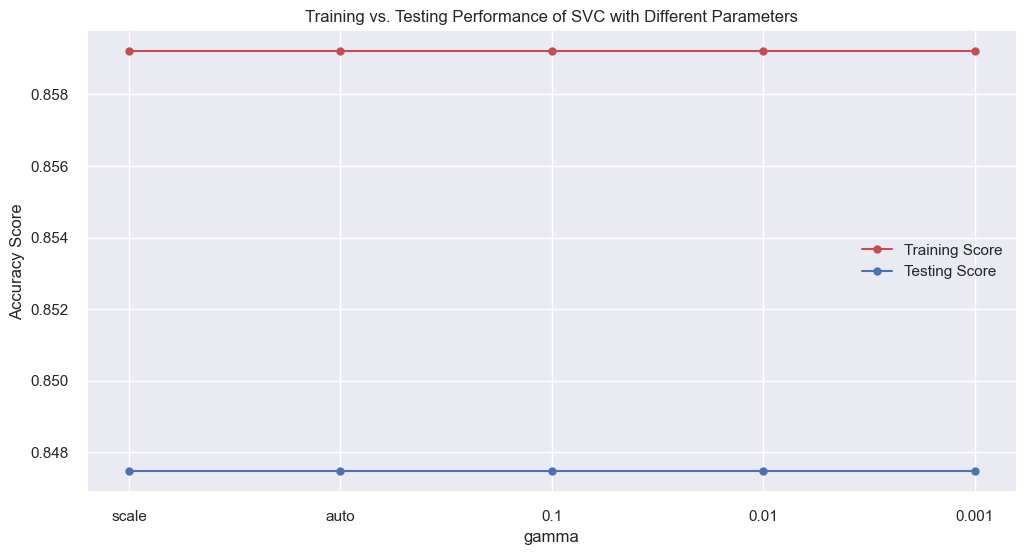

CPU times: total: 406 ms
Wall time: 2.51 s


In [158]:
%%time
param_svm = {
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
}

evaluate_model_with_gridsearch(svm_classifier, param_svm, X_FS, Y_FS)

Best Parameters: {'kernel': 'linear'}
Test Accuracy Score for Best Parameters: 0.8475


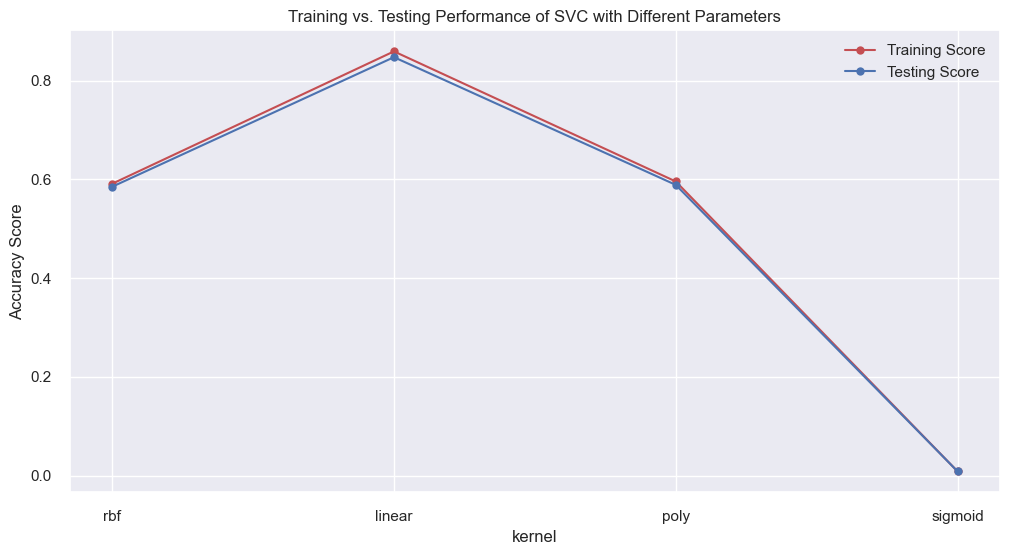

CPU times: total: 422 ms
Wall time: 2.21 s


In [159]:
%%time
param_svm = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

evaluate_model_with_gridsearch(svm_classifier, param_svm, X_FS, Y_FS)

param_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

Best Parameters: {'hidden_layer_sizes': (100, 50)}
Test Accuracy Score for Best Parameters: 0.7527


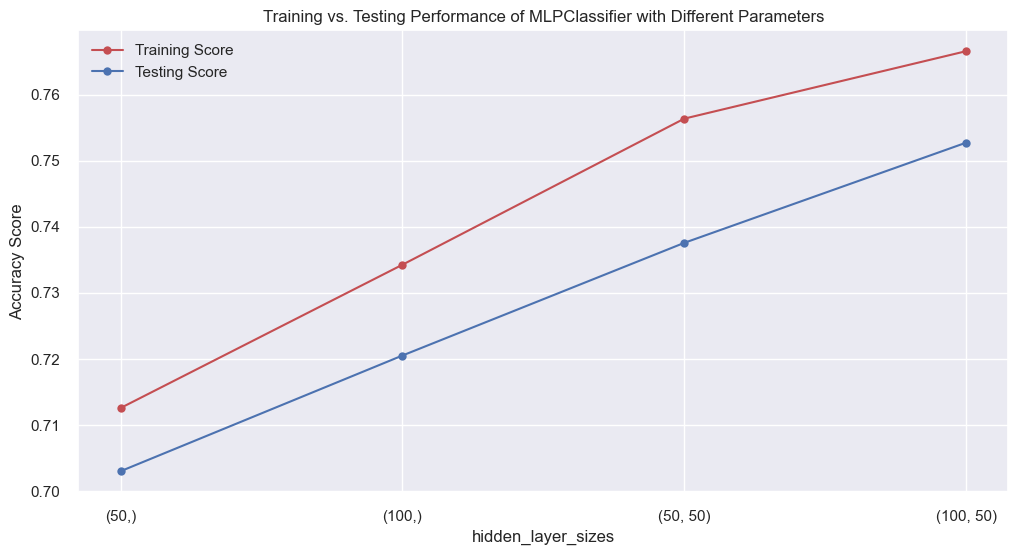

CPU times: total: 8.03 s
Wall time: 12.1 s


In [160]:
%%time
param_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
}

evaluate_model_with_gridsearch(mlp_classifier, param_mlp, X_FS, Y_FS)

Best Parameters: {'activation': 'tanh'}
Test Accuracy Score for Best Parameters: 0.7736


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


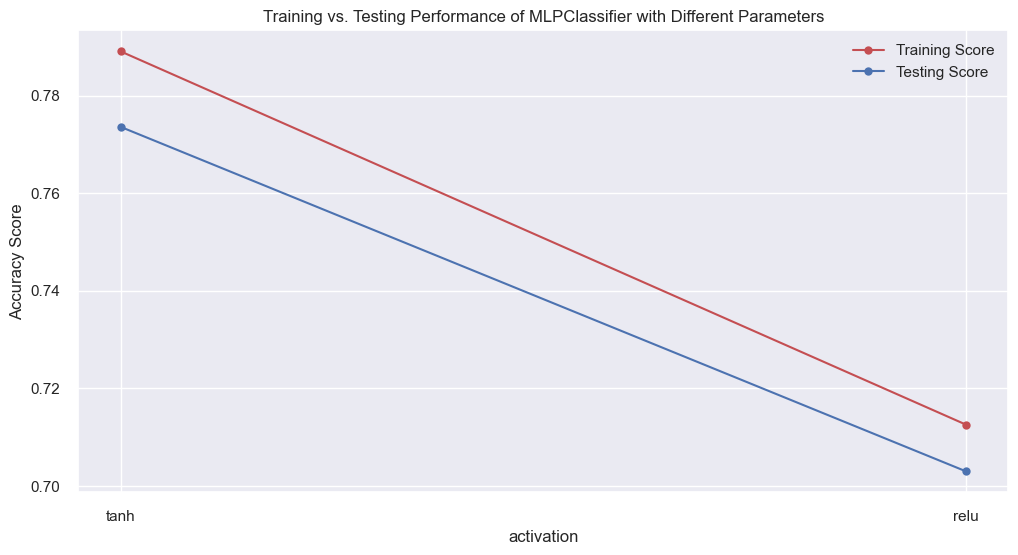

CPU times: total: 1.09 s
Wall time: 4.56 s


In [161]:
%%time
param_mlp = {
    'activation': ['tanh', 'relu'],
}

evaluate_model_with_gridsearch(mlp_classifier, param_mlp, X_FS, Y_FS)

Best Parameters: {'solver': 'adam'}
Test Accuracy Score for Best Parameters: 0.7030


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


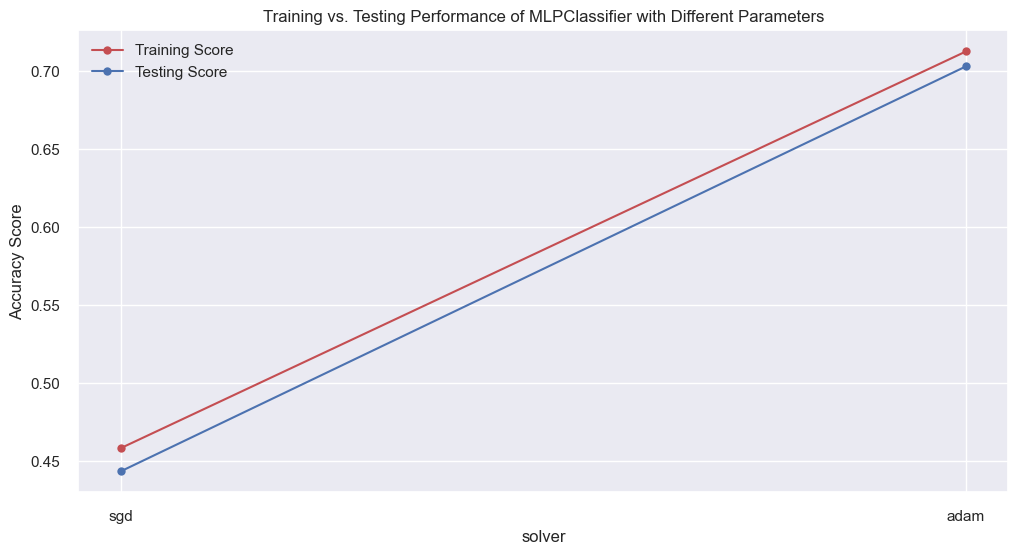

CPU times: total: 1.17 s
Wall time: 3.55 s


In [162]:
%%time
param_mlp = {
    'solver': ['sgd', 'adam'],
}

evaluate_model_with_gridsearch(mlp_classifier, param_mlp, X_FS, Y_FS)

Best Parameters: {'alpha': 0.0001}
Test Accuracy Score for Best Parameters: 0.7030


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


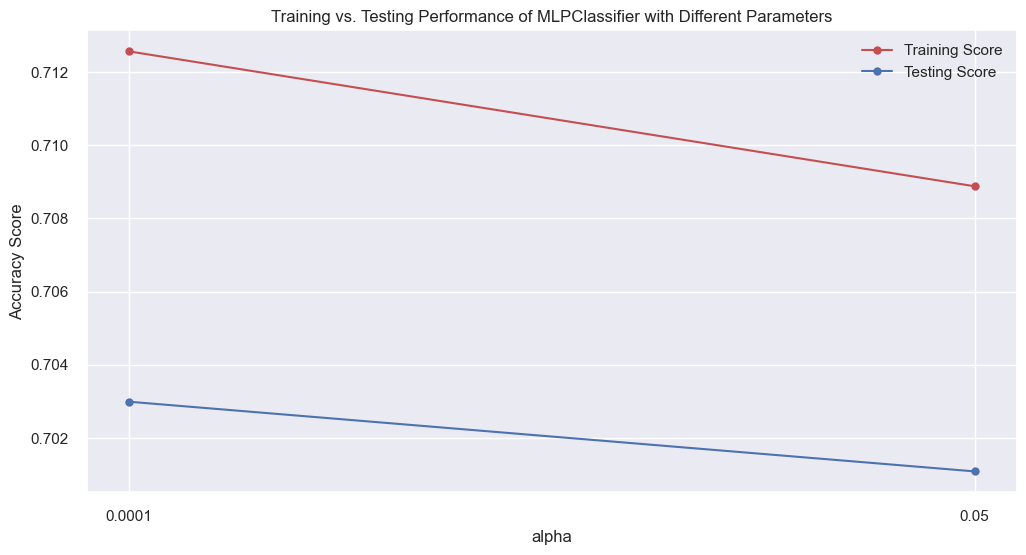

CPU times: total: 1.14 s
Wall time: 4.53 s


In [163]:
%%time
param_mlp = {
    'alpha': [0.0001, 0.05],
}

evaluate_model_with_gridsearch(mlp_classifier, param_mlp, X_FS, Y_FS)

Best Parameters: {'learning_rate': 'constant'}
Test Accuracy Score for Best Parameters: 0.7030


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


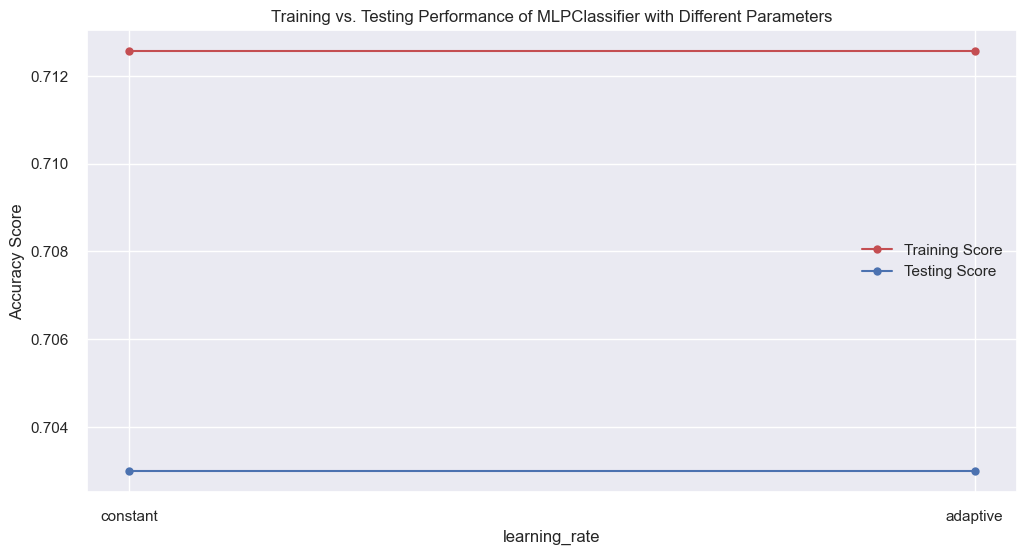

CPU times: total: 1.17 s
Wall time: 4.89 s


In [164]:
%%time
param_mlp = {
    'learning_rate': ['constant', 'adaptive'],
}

evaluate_model_with_gridsearch(mlp_classifier, param_mlp, X_FS, Y_FS)

param_XGB = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

Best Parameters: {'n_estimators': 100}
Test Accuracy Score for Best Parameters: 0.9730


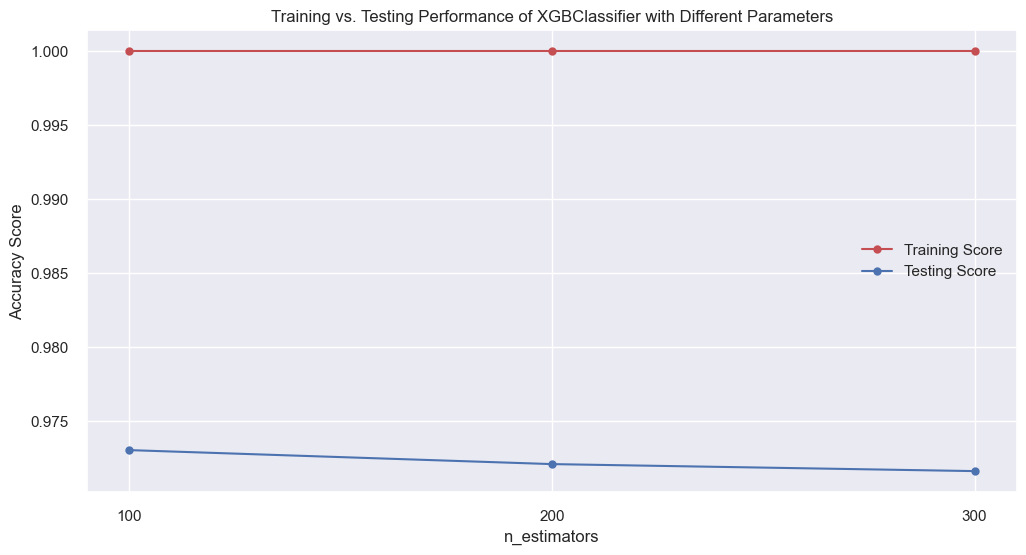

CPU times: total: 7.03 s
Wall time: 2.49 s


In [165]:
%%time
param_XGB = {
    'n_estimators': [100, 200, 300],
}

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_FS, Y_FS)

Best Parameters: {'max_depth': 6}
Test Accuracy Score for Best Parameters: 0.9730


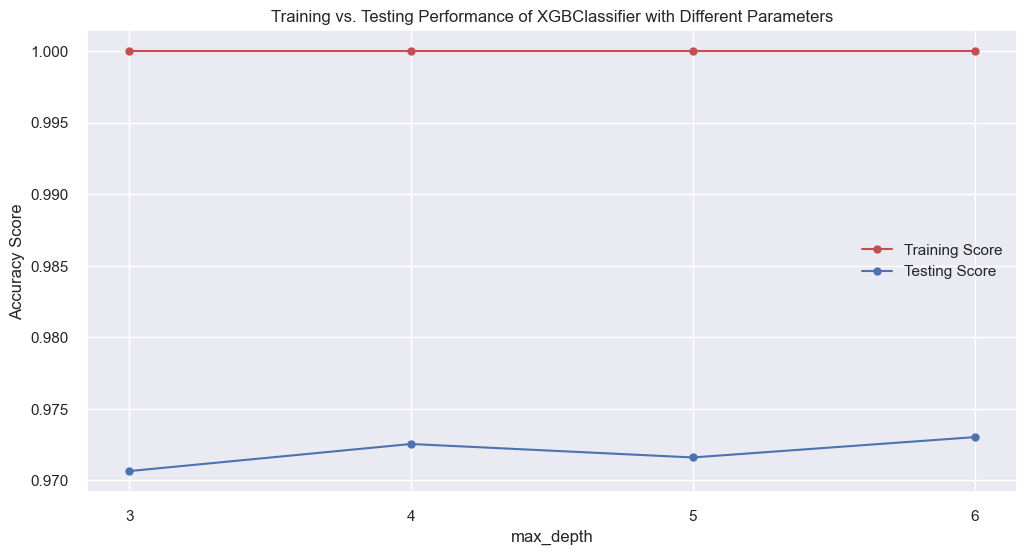

CPU times: total: 9.2 s
Wall time: 2.06 s


In [166]:
%%time
param_XGB = {
    'max_depth': [3, 4, 5, 6],
}

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_FS, Y_FS)

Best Parameters: {'learning_rate': 0.1}
Test Accuracy Score for Best Parameters: 0.9726


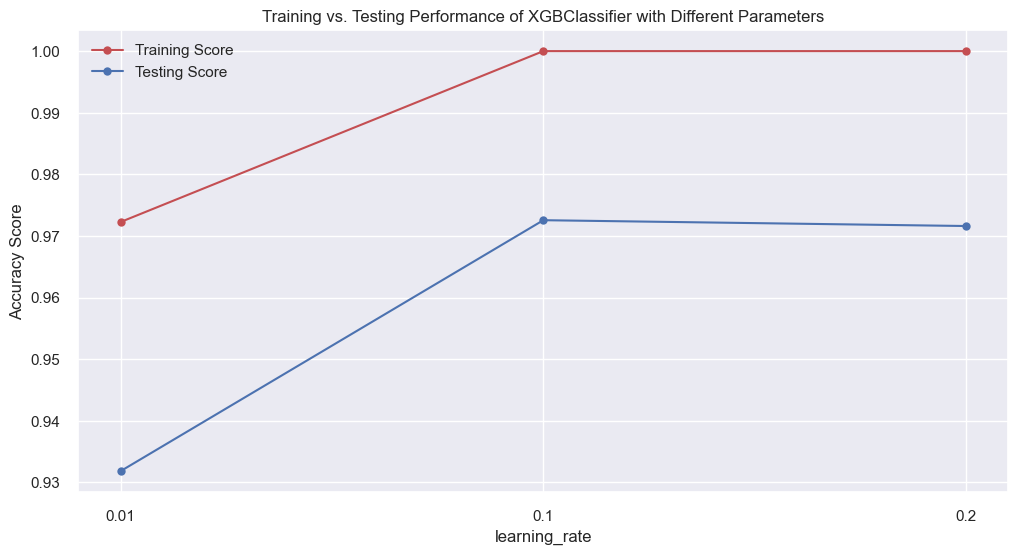

CPU times: total: 7.05 s
Wall time: 1.86 s


In [167]:
%%time
param_XGB = {
    'learning_rate': [0.01, 0.1, 0.2],
}

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_FS, Y_FS)

Best Parameters: {'subsample': 1.0}
Test Accuracy Score for Best Parameters: 0.9730


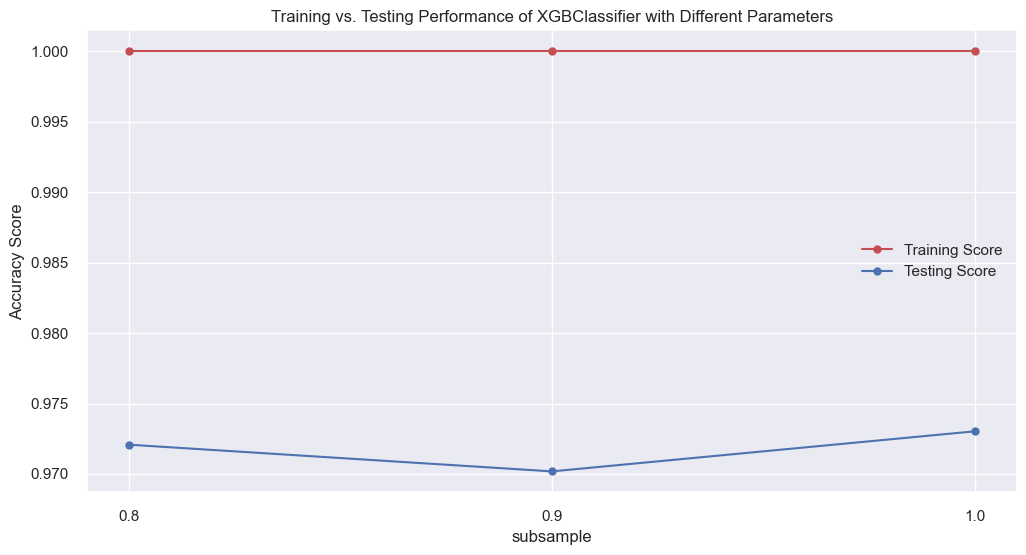

CPU times: total: 8.55 s
Wall time: 1.9 s


In [168]:
%%time
param_XGB = {
    'subsample': [0.8, 0.9, 1.0],
}

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_FS, Y_FS)

Best Parameters: {'colsample_bytree': 1.0}
Test Accuracy Score for Best Parameters: 0.9730


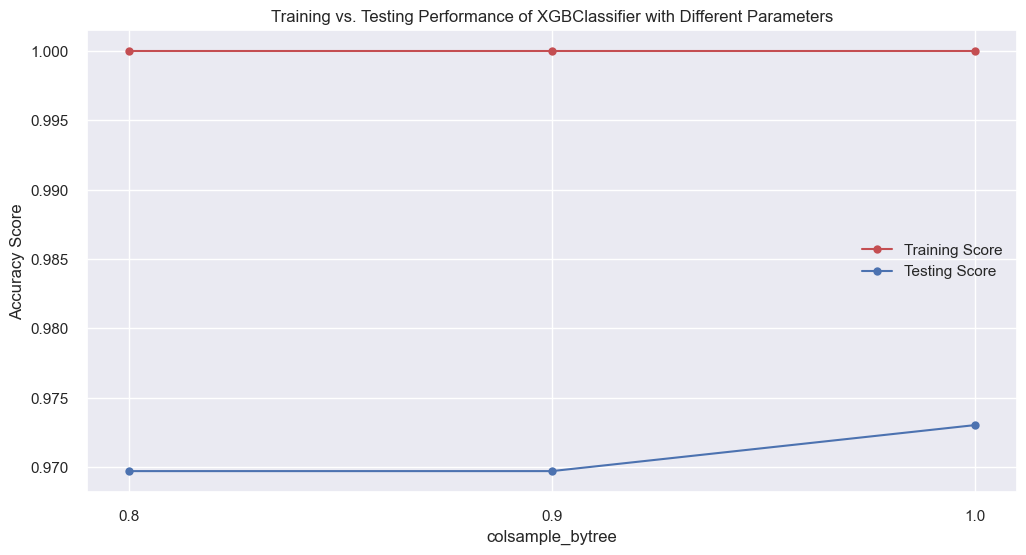

CPU times: total: 6.86 s
Wall time: 1.71 s


In [169]:
%%time
param_XGB = {
    'colsample_bytree': [0.8, 0.9, 1.0]
}

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_FS, Y_FS)

# Final Model Training and Testing applying best parameters obtained

Decision Tree Classifier Accuracy: 0.9432624113475178
Decision Tree Training Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.93      0.96      0.95        57
           2       0.88      0.93      0.91        74
           3       0.94      0.89      0.92        57
           4       0.98      0.98      0.98        62
           5       0.95      0.92      0.93        59
           6       0.95      0.92      0.93        59

    accuracy                           0.94       423
   macro avg       0.95      0.94      0.94       423
weighted avg       0.94      0.94      0.94       423



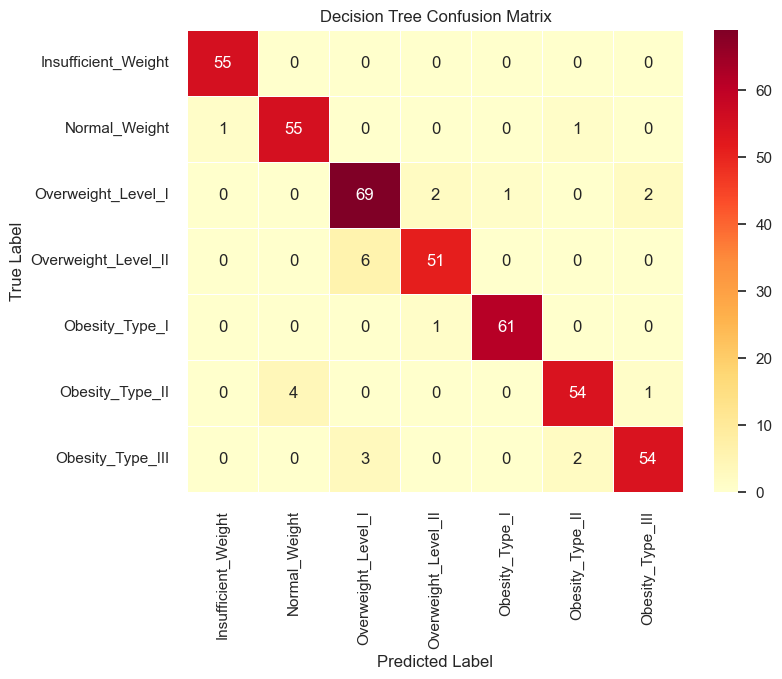

---------------------------------------------------------------------
Random Forest Classifier Accuracy: 0.9881796690307328
Random Forest Training Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.96      0.98        57
           2       0.99      0.99      0.99        74
           3       1.00      0.98      0.99        57
           4       1.00      1.00      1.00        62
           5       0.98      0.98      0.98        59
           6       0.97      1.00      0.98        59

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



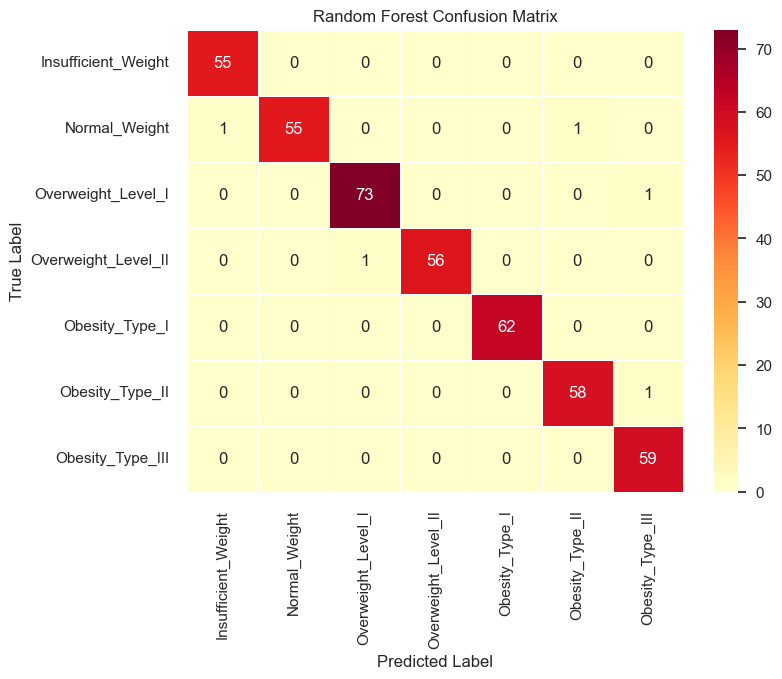

---------------------------------------------------------------------
K-Nearest Neighbor Classifier Accuracy: 0.9574468085106383
K-Nearest Neighbor Training Accuracy: 1.0
K-Nearest Neighbor Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.89      0.94        57
           2       0.95      0.95      0.95        74
           3       1.00      0.98      0.99        57
           4       0.98      1.00      0.99        62
           5       0.90      0.97      0.93        59
           6       0.90      0.92      0.91        59

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423



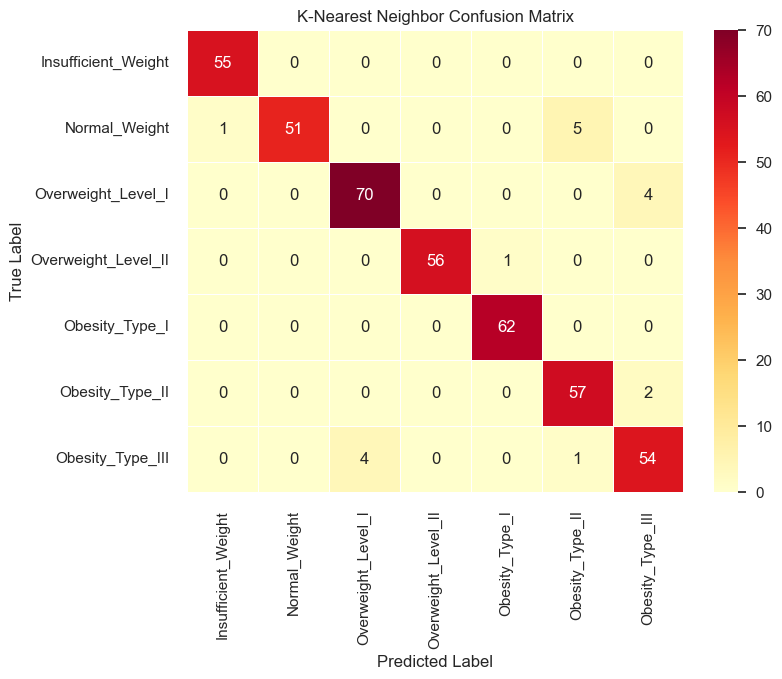

---------------------------------------------------------------------
Support Vector Machine Classifier Accuracy: 0.966903073286052
Support Vector Machine Training Accuracy: 0.965047393364929
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       0.98      0.96      0.97        57
           2       0.96      0.96      0.96        74
           3       0.98      0.95      0.96        57
           4       0.97      1.00      0.98        62
           5       0.95      0.98      0.97        59
           6       0.96      0.92      0.94        59

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423



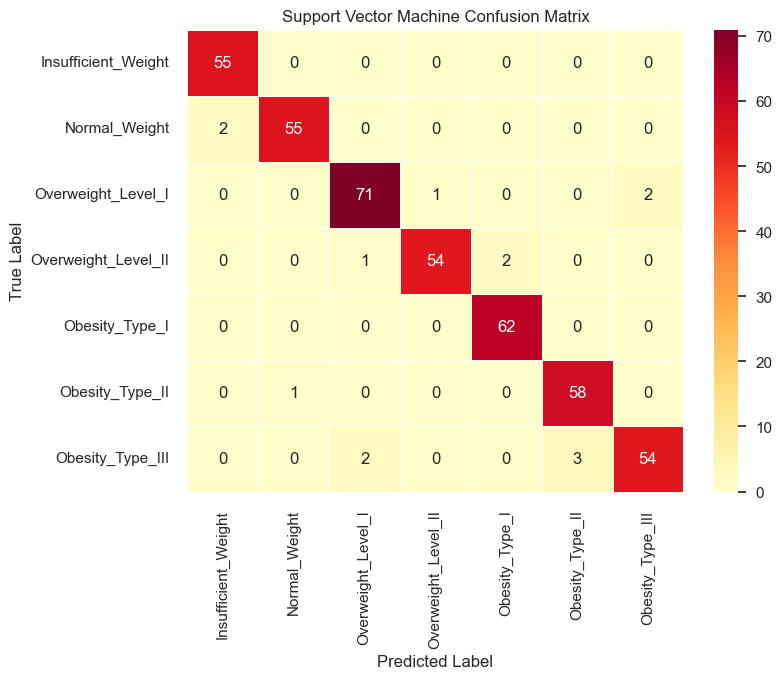

---------------------------------------------------------------------


C:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi-Layer Perceptron Classifier Accuracy: 0.9787234042553191
Multi-Layer Perceptron Training Accuracy: 0.9863744075829384
Multi-Layer Perceptron Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        55
           1       1.00      0.95      0.97        57
           2       0.99      0.99      0.99        74
           3       0.98      0.95      0.96        57
           4       0.97      1.00      0.98        62
           5       0.97      1.00      0.98        59
           6       1.00      0.97      0.98        59

    accuracy                           0.98       423
   macro avg       0.98      0.98      0.98       423
weighted avg       0.98      0.98      0.98       423



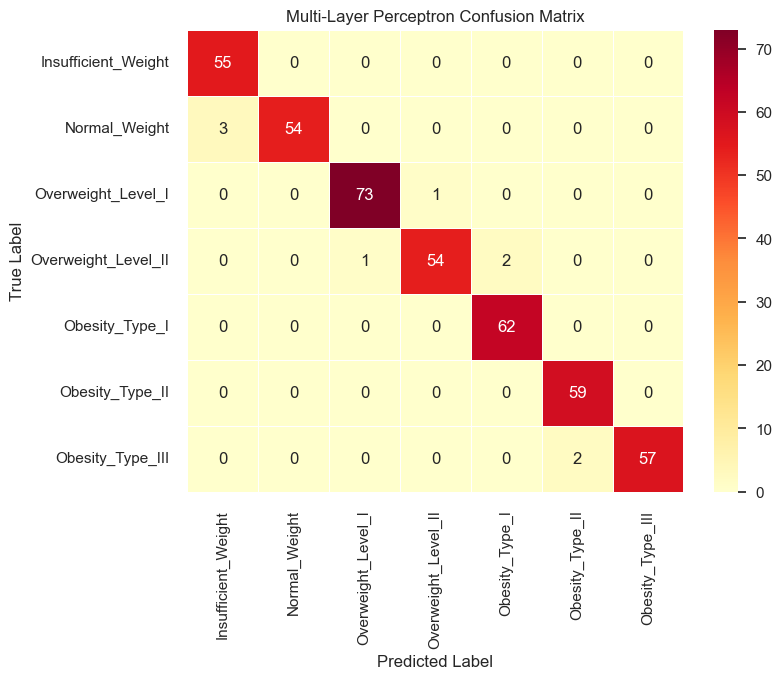

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.9810874704491725
XGBoost Training Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.98      0.98      0.98        57
           2       1.00      1.00      1.00        74
           3       0.98      0.98      0.98        57
           4       0.98      0.98      0.98        62
           5       0.94      0.98      0.96        59
           6       1.00      0.93      0.96        59

    accuracy                           0.98       423
   macro avg       0.98      0.98      0.98       423
weighted avg       0.98      0.98      0.98       423



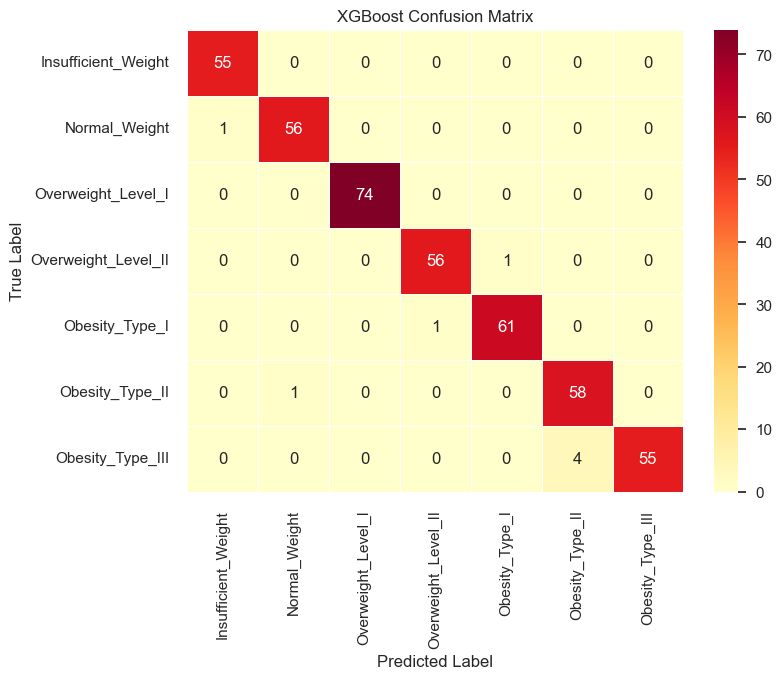

---------------------------------------------------------------------


In [307]:
DT_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth =  12,random_state=19)
knn_classifier = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 3, weights = 'distance')
svm_classifier = SVC(C=100, gamma = 'scale',kernel='linear', random_state=19)
mlp_classifier = MLPClassifier(solver='adam',activation = 'tanh',
                               alpha = 0.0001, hidden_layer_sizes = (100, 50),
                               learning_rate = 'constant',random_state=19)
XGB_classifier = xgb.XGBClassifier(colsample_bytree = 1.0, learning_rate = 0.1, max_depth = 6, n_estimators = 100,
                                   subsample = 1.0, random_state=19)
RF_classifier = RandomForestClassifier(bootstrap = False, max_depth= 20,
                                       min_samples_leaf= 1, min_samples_split= 4,
                                       n_estimators=200,random_state=19)

classifier = {
    'Decision Tree': DT_classifier,
    'Random Forest':RF_classifier,
    'K-Nearest Neighbor': knn_classifier,
    'Support Vector Machine': svm_classifier,
    'Multi-Layer Perceptron': mlp_classifier,
    'XGBoost':XGB_classifier
}

f1_scores = evaluate_classifiers(classifier, X_train_FS, Y_train_FS, X_test_FS, Y_test_FS, sorted_labels)

## ROC Curve (One vs Rest) after applying best parameters

In [ ]:
def plot_roc_curves(models, class_types, X_train, X_test, y_train, y_test):
    """
    Plots ROC curves for all models using Yellowbrick's ROCAUC visualizer.
    
    """
    # Subplot grid dimensions
    n_models = len(models)
    ncols = 3
    nrows = int(np.ceil(n_models / ncols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    
    axes = axes.flatten()
    
    # Plot ROC curve for each model
    for idx, (name, model) in enumerate(models.items()):
        visualizer = ROCAUC(model, classes=class_types, ax=axes[idx], is_fitted="auto")
        
        # Fit the training data, then evaluate the model on the test data
        visualizer.fit(X_train, y_train)        
        visualizer.score(X_test, y_test)        
        
        # Set the subplot title to the name of the model
        visualizer.ax.set_title(name)
        
        visualizer.ax.legend()
            
    plt.legend()
    plt.tight_layout()
    plt.show()

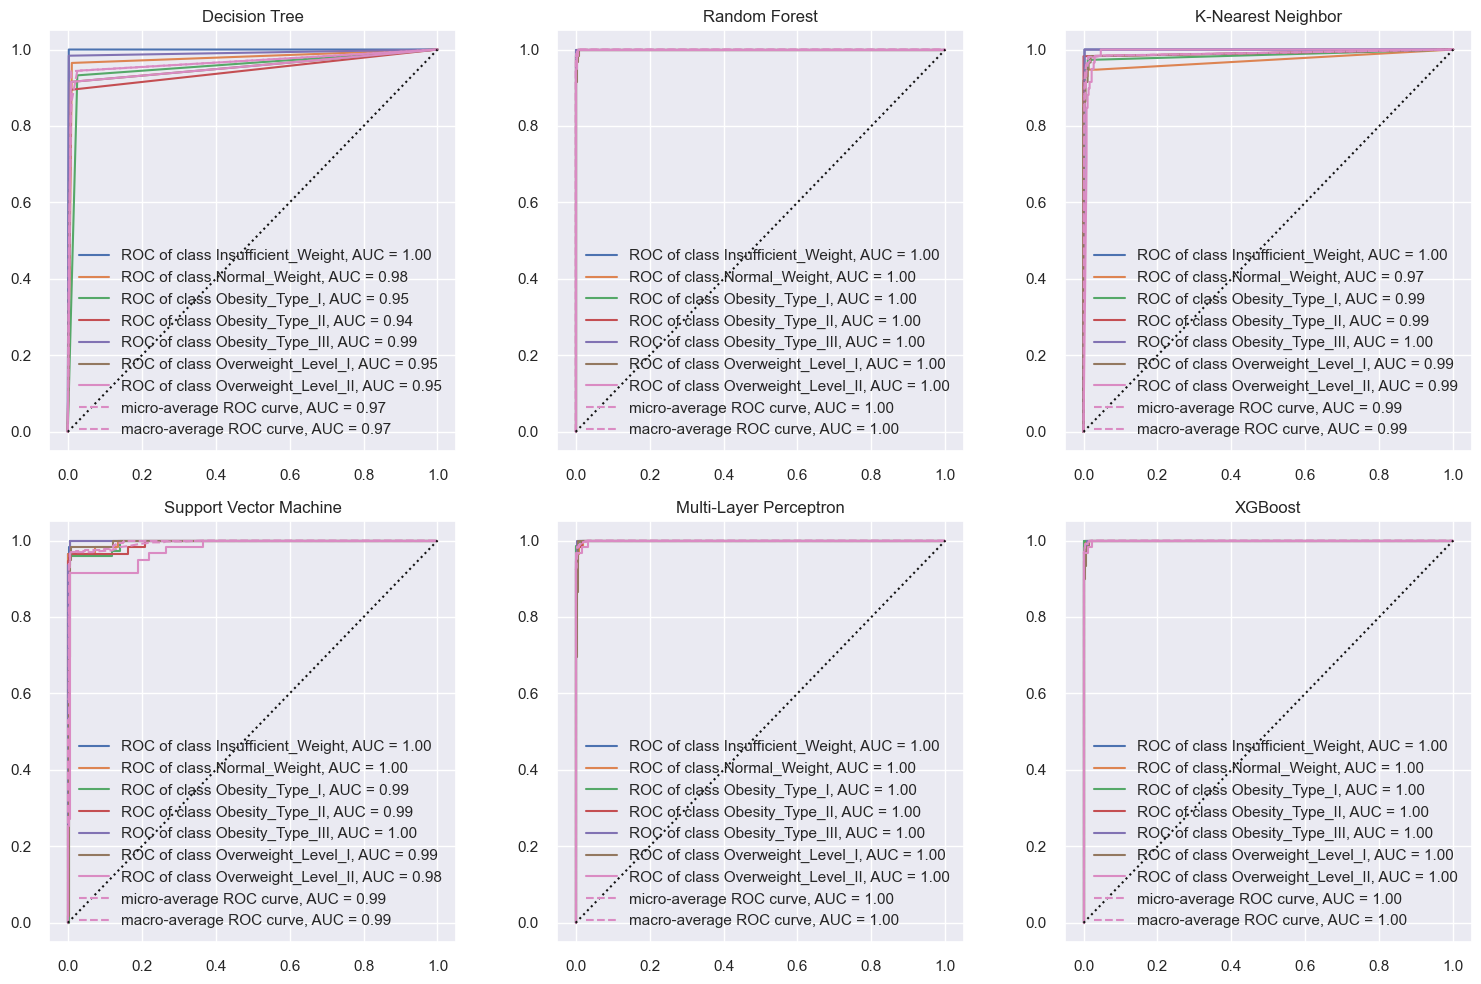

In [290]:
models = {
    'Decision Tree': DT_classifier,
    'Random Forest':RF_classifier,
    'K-Nearest Neighbor': knn_classifier,
    'Support Vector Machine': svm_classifier,
    'Multi-Layer Perceptron': mlp_classifier,
    'XGBoost':XGB_classifier
}

plot_roc_curves(models, class_types, X_train_FS, X_test_FS, Y_train_FS, Y_test_FS)